# Data Pre-Processing

## Data Loading
- **File Reading:** Load signal files from the specified directories for healthy and patient groups
- **Label Assignment:** Assign a numerical label to each file based on its category (healthy or patient) for supervised learning.

In [1]:
# Cell 1: Imports and Setup (Updated channel names)
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import re

pd.set_option('display.max_columns', None)

# Base paths configuration
base_paths = {
    "healthy": r"C:\NewHandPD\Healthy Signals\Signal",
    "patient": r"C:\NewHandPD\Patient Signals\Signal"
}

category_labels = {
    "healthy": 0,
    "patient": 1
}

# Updated channel names (excluding Microphone)
channel_names = [
    "Fingergrip", "Axial_Pressure",
    "Tilt_X", "Tilt_Y", "Tilt_Z"
]

## Data Parsing
- **Metadata Extraction:** Extract relevant metadata from each file, such as subject information and recording parameters, to enrich the dataset.
- **Signal Processing:** Parse and structure the signal data, dropping unnecessary channels (e.g., Microphone) and keeping only the relevant sensor channels.

In [2]:
# Cell 2: Enhanced File Parsing Function with Metadata Extraction
def parse_signal_file(file_path, label):
    with open(file_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()

    meta_info = {}
    signal_start_idx = 0
    in_meta_section = False

    # Extract metadata
    for i, line in enumerate(lines):
        line = line.strip()
        
        if line == "#<meta>":
            in_meta_section = True
            continue
        elif line == "#</meta>":
            in_meta_section = False
            signal_start_idx = i + 1
            break
            
        if in_meta_section and line.startswith("#<") and line.endswith(">"):
            # Extract key-value pairs from metadata
            try:
                key = line[2:line.find(">")]  # Get text between #< and >
                value = line[line.find(">")+1:-1]  # Get text between > and <
                
                # Convert numeric values to appropriate type
                if value.isdigit():
                    value = int(value)
                elif value.replace('.', '', 1).isdigit():
                    value = float(value)
                elif value.lower() == 'true':
                    value = True
                elif value.lower() == 'false':
                    value = False
                elif value == '':
                    value = None
                    
                meta_info[key] = value
            except:
                continue

    # Load signal data and drop first channel (Microphone)
    signal_lines = lines[signal_start_idx:]
    signal_array = np.loadtxt(signal_lines, delimiter="\t")
    
    # Keep only channels 1-5 (drop channel 0 - Microphone)
    if signal_array.ndim == 1:
        signal_array = signal_array[1:6].reshape(1, -1)  # For single-row signals
    else:
        signal_array = signal_array[:, 1:6]  # For multi-row signals

    return signal_array, label, meta_info

In [3]:
# Cell 3: Main Processing (with selected metadata fields only)
all_records = []
sigMea_records = []
sigSp_records = []

# Define the metadata fields we want to keep
metadata_fields = ['Person_ID_Number', 'Age', 'Gender', 'Writing_Hand']

for category, folder_path in base_paths.items():
    label = category_labels[category]
    print(f"Processing {category} files...")

    for file_name in tqdm(os.listdir(folder_path)):
        if not file_name.endswith(".txt"):
            continue
            
        file_path = os.path.join(folder_path, file_name)
        try:
            signal_data, label_val, meta_info = parse_signal_file(file_path, label)

            # Filter metadata to only include specified fields
            filtered_meta = {k: meta_info[k] for k in metadata_fields if k in meta_info}

            record = {
                "file_name": file_name,
                "label": label_val,
                "signal": signal_data,
                **filtered_meta  # Unpack only the filtered metadata into the record
            }

            all_records.append(record)
            
            # Filter for specific file prefixes
            if file_name.startswith("sigMea"):
                sigMea_records.append(record)
            elif file_name.startswith("sigSp"):
                sigSp_records.append(record)

        except Exception as e:
            print(f"Error parsing {file_name}: {e}")

Processing healthy files...


100%|██████████| 421/421 [00:06<00:00, 63.42it/s]


Processing patient files...


100%|██████████| 373/373 [00:11<00:00, 33.26it/s]


In [4]:
# Cell 4: Create DataFrames (Now includes metadata columns)
df_all = pd.DataFrame(all_records)
df_sigMea = pd.DataFrame(sigMea_records)
df_sigSp = pd.DataFrame(sigSp_records)

print(f"\nSummary:")
print(f"Total files processed: {len(all_records)}")
print(f"Files starting with 'sigMea': {len(sigMea_records)}")
print(f"Files starting with 'sigSp': {len(sigSp_records)}")

# Show metadata columns we've extracted
print("\nMetadata columns found:")
print([col for col in df_all.columns if col not in ['file_name', 'label', 'signal']])


Summary:
Total files processed: 792
Files starting with 'sigMea': 264
Files starting with 'sigSp': 264

Metadata columns found:
['Person_ID_Number', 'Age', 'Gender', 'Writing_Hand']


In [5]:
# Cell 4.1: Keep only the core metadata columns

core_cols = ['file_name', 'label', 'signal', 'Person_ID_Number', 'Age', 'Gender', 'Writing_Hand']

def select_existing_cols(df, cols):
    existing_cols = [col for col in cols if col in df.columns]
    return df[existing_cols]

df_all = select_existing_cols(df_all, core_cols)
df_sigMea = select_existing_cols(df_sigMea, core_cols)
df_sigSp = select_existing_cols(df_sigSp, core_cols)

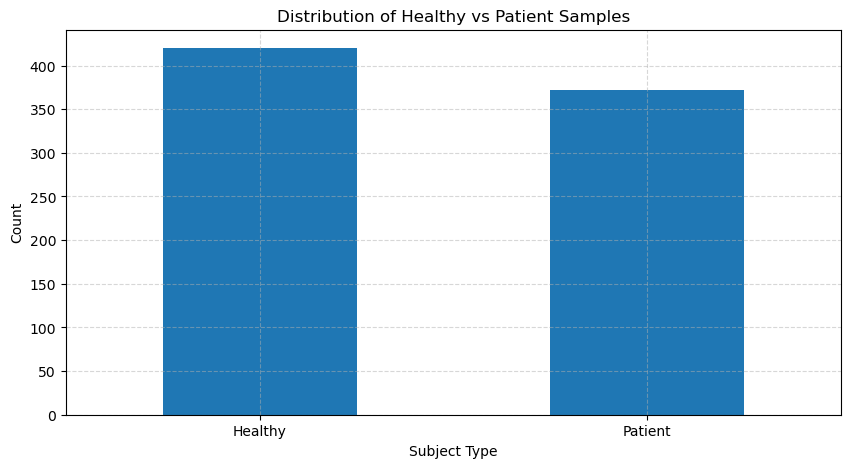

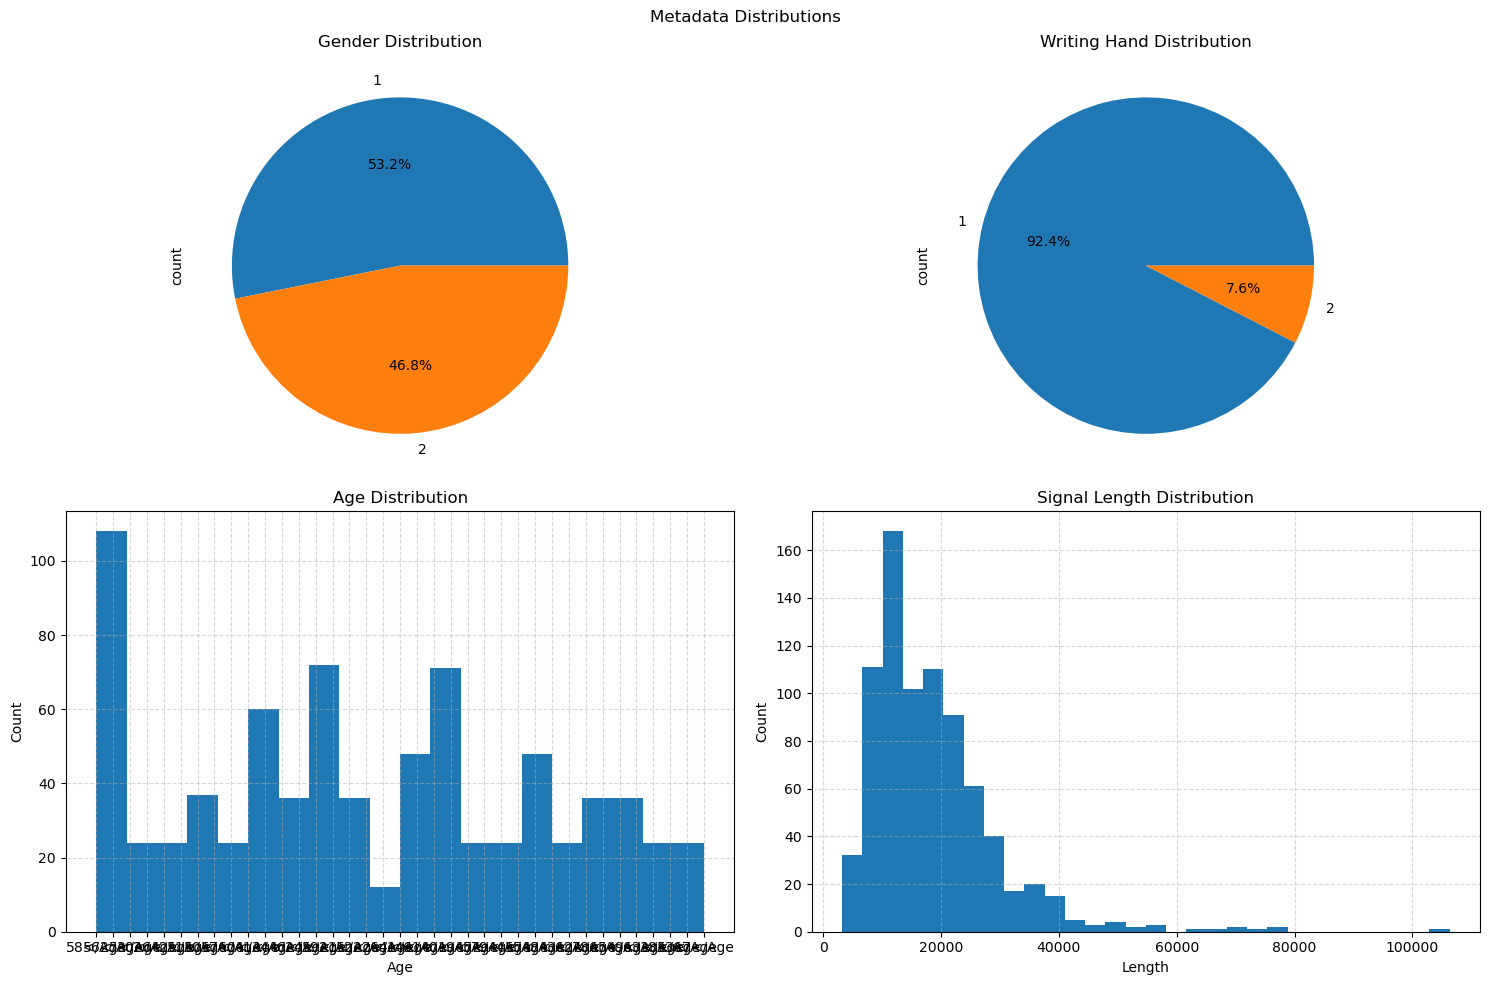

Example Healthy Signals:


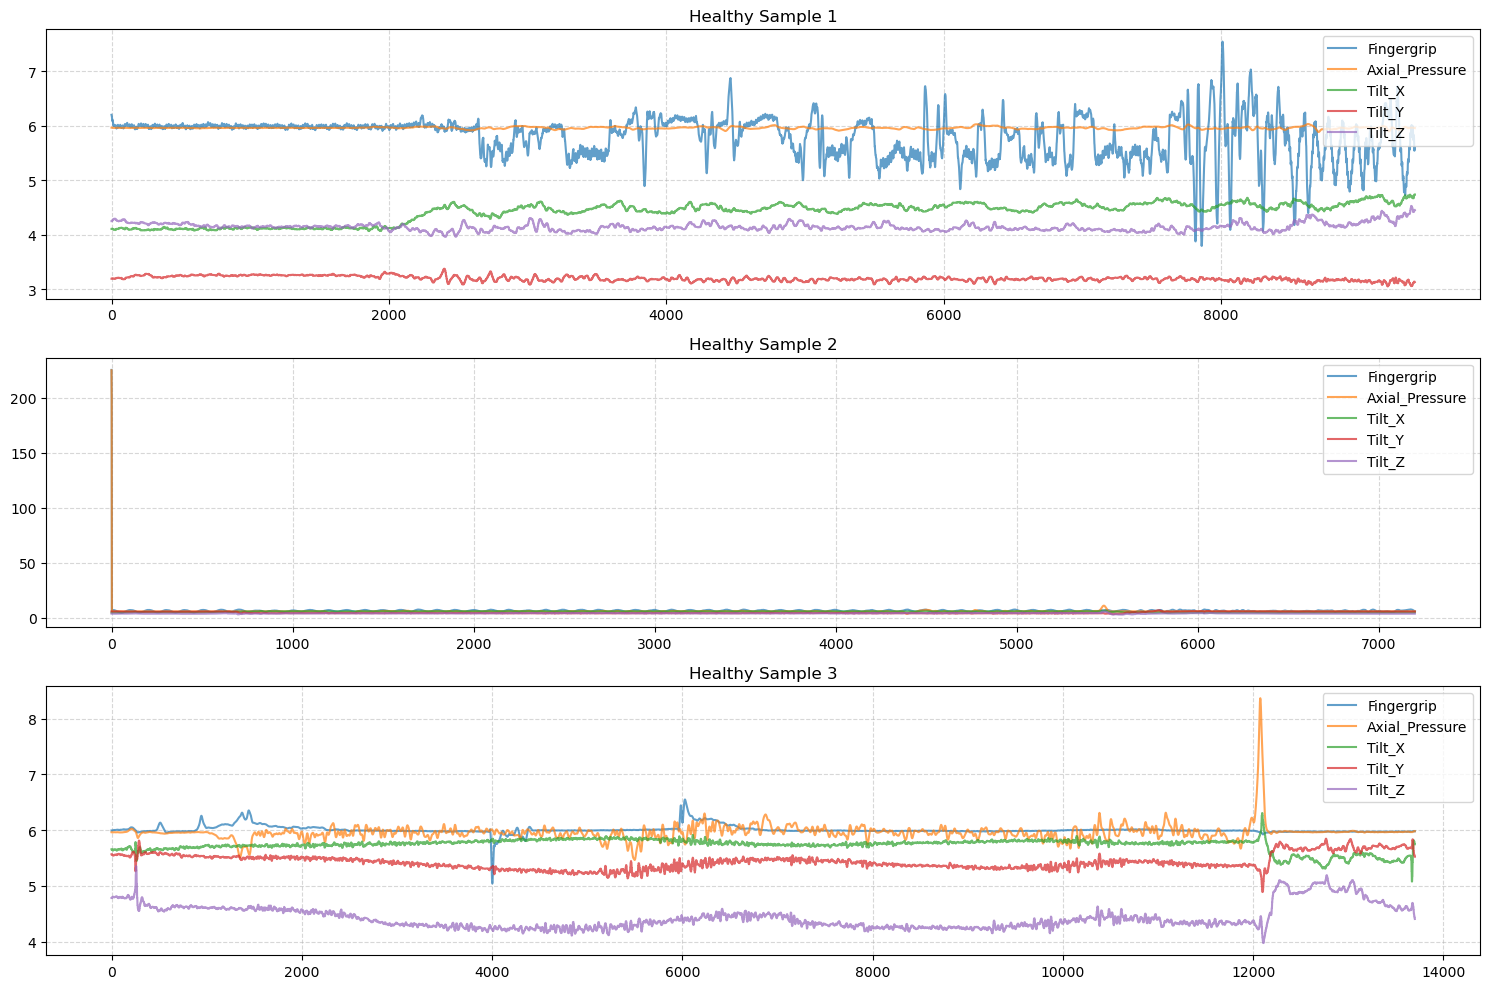


Example Patient Signals:


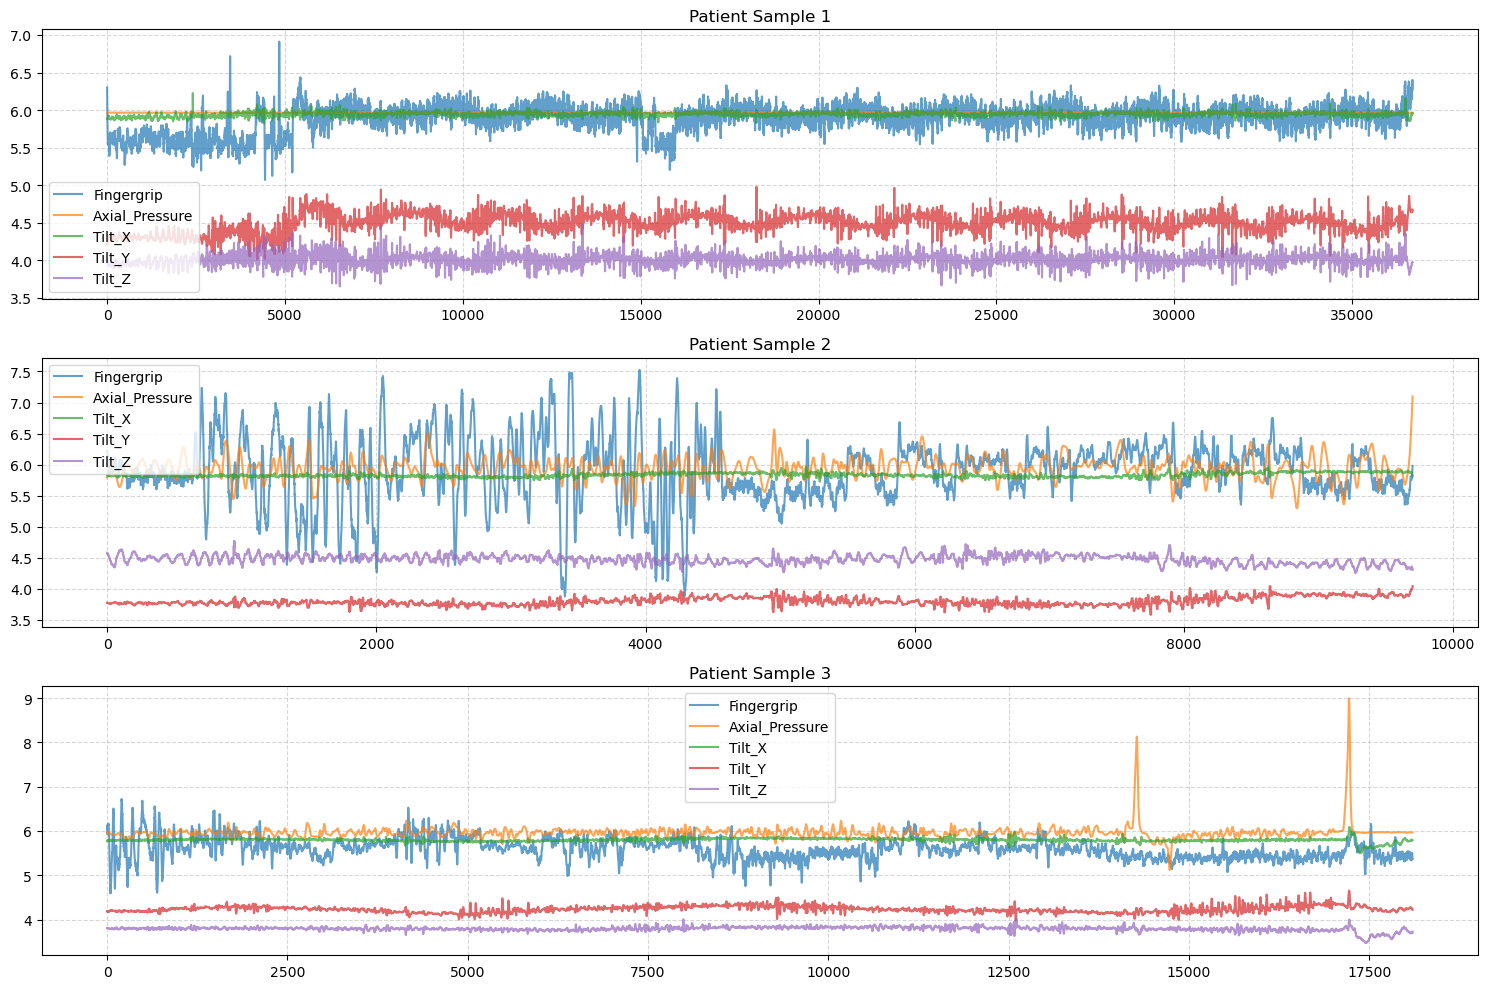

In [6]:
# Data Visualization after loading
import matplotlib.pyplot as plt

# Set up the plotting style
try:
    plt.style.use('seaborn')
except:
    # If seaborn style is not available, use a clean default style
    plt.style.use('default')
    plt.rcParams['figure.facecolor'] = 'white'
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.linestyle'] = '--'
    plt.rcParams['grid.alpha'] = 0.5

plt.rcParams['figure.figsize'] = [12, 6]

# 1. Plot distribution of labels (healthy vs patient)
plt.figure(figsize=(10, 5))
df_all['label'].map({0: 'Healthy', 1: 'Patient'}).value_counts().plot(kind='bar')
plt.title('Distribution of Healthy vs Patient Samples')
plt.xlabel('Subject Type')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

# 2. Plot metadata distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Metadata Distributions')

# Gender distribution
gender_counts = df_all['Gender'].value_counts()
gender_counts.index = gender_counts.index.str.replace('</Gender', '')  # Clean up labels
gender_counts.plot(kind='pie', ax=axes[0,0], autopct='%1.1f%%')
axes[0,0].set_title('Gender Distribution')

# Writing Hand distribution
hand_counts = df_all['Writing_Hand'].value_counts()
hand_counts.index = hand_counts.index.str.replace('</Writing_Hand', '')  # Clean up labels
hand_counts.plot(kind='pie', ax=axes[0,1], autopct='%1.1f%%')
axes[0,1].set_title('Writing Hand Distribution')

# Age distribution
df_all['Age'].hist(ax=axes[1,0], bins=20)
axes[1,0].set_title('Age Distribution')
axes[1,0].set_xlabel('Age')
axes[1,0].set_ylabel('Count')

# Signal lengths
signal_lengths = df_all['signal'].apply(len)
signal_lengths.hist(ax=axes[1,1], bins=30)
axes[1,1].set_title('Signal Length Distribution')
axes[1,1].set_xlabel('Length')
axes[1,1].set_ylabel('Count')

plt.tight_layout()
plt.show()

# 3. Plot example signals
def plot_example_signals(df, category, num_examples=3):
    plt.figure(figsize=(15, 10))
    examples = df[df['label'] == category].sample(n=num_examples)
    
    for idx, (_, row) in enumerate(examples.iterrows(), 1):
        signal = row['signal']
        plt.subplot(num_examples, 1, idx)
        for i, channel in enumerate(channel_names):
            plt.plot(signal[:, i], label=channel, alpha=0.7)
        plt.title(f"{'Patient' if category == 1 else 'Healthy'} Sample {idx}")
        plt.legend()
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()

print("Example Healthy Signals:")
plot_example_signals(df_all, category=0)
print("\nExample Patient Signals:")
plot_example_signals(df_all, category=1)

## Data Cleaning
- **Missing and Outlier Data Handling:** Remove records with missing values or impossible signal values (e.g., negative physical measurements) to ensure data quality.
- **Signal Normalization:** Apply min-max scaling to each signal channel so all features are on a comparable scale, improving model performance and interpretability.

In [7]:
# Cell 5: Data Cleaning for DataFrames
# Remove rows with missing or NaN values in key columns
df_all_clean = df_all.dropna(subset=['signal', 'label', 'file_name'])
df_sigMea_clean = df_sigMea.dropna(subset=['signal', 'label', 'file_name'])
df_sigSp_clean = df_sigSp.dropna(subset=['signal', 'label', 'file_name'])

# Remove rows with impossible values (e.g., negative values for physical signals)
def remove_impossible_values(df):
    # Example: Remove rows where any signal value is negative
    mask = df['signal'].apply(lambda x: np.all(x >= 0))
    return df[mask]

df_all_clean = remove_impossible_values(df_all_clean)
df_sigMea_clean = remove_impossible_values(df_sigMea_clean)
df_sigSp_clean = remove_impossible_values(df_sigSp_clean)

# Normalize signal data (min-max scaling per sample)
def normalize_signal(signal):
    min_val = np.min(signal, axis=0)
    max_val = np.max(signal, axis=0)
    # Avoid division by zero
    denom = np.where(max_val - min_val == 0, 1, max_val - min_val)
    return (signal - min_val) / denom

df_all_clean['signal'] = df_all_clean['signal'].apply(normalize_signal)
df_sigMea_clean['signal'] = df_sigMea_clean['signal'].apply(normalize_signal)
df_sigSp_clean['signal'] = df_sigSp_clean['signal'].apply(normalize_signal)

print('Data cleaning complete:')
print(f'df_all_clean shape: {df_all_clean.shape}')
print(f'df_sigMea_clean shape: {df_sigMea_clean.shape}')
print(f'df_sigSp_clean shape: {df_sigSp_clean.shape}')

# Check for missing values in each DataFrame
print("\nMissing values in df_all_clean:", df_all_clean.isna().sum().sum())
print("Missing values in df_sigMea_clean:", df_sigMea_clean.isna().sum().sum())
print("Missing values in df_sigSp_clean:", df_sigSp_clean.isna().sum().sum())

# To see which columns have missing values:
print("\nColumns with missing values in df_all_clean:")
print(df_all_clean.isna().sum()[df_all_clean.isna().sum() > 0])

print("\nColumns with missing values in df_sigMea_clean:")
print(df_sigMea_clean.isna().sum()[df_sigMea_clean.isna().sum() > 0])

print("\nColumns with missing values in df_sigSp_clean:")
print(df_sigSp_clean.isna().sum()[df_sigSp_clean.isna().sum() > 0])

Data cleaning complete:
df_all_clean shape: (789, 7)
df_sigMea_clean shape: (262, 7)
df_sigSp_clean shape: (263, 7)

Missing values in df_all_clean: 0
Missing values in df_sigMea_clean: 0
Missing values in df_sigSp_clean: 0

Columns with missing values in df_all_clean:
Series([], dtype: int64)

Columns with missing values in df_sigMea_clean:
Series([], dtype: int64)

Columns with missing values in df_sigSp_clean:
Series([], dtype: int64)


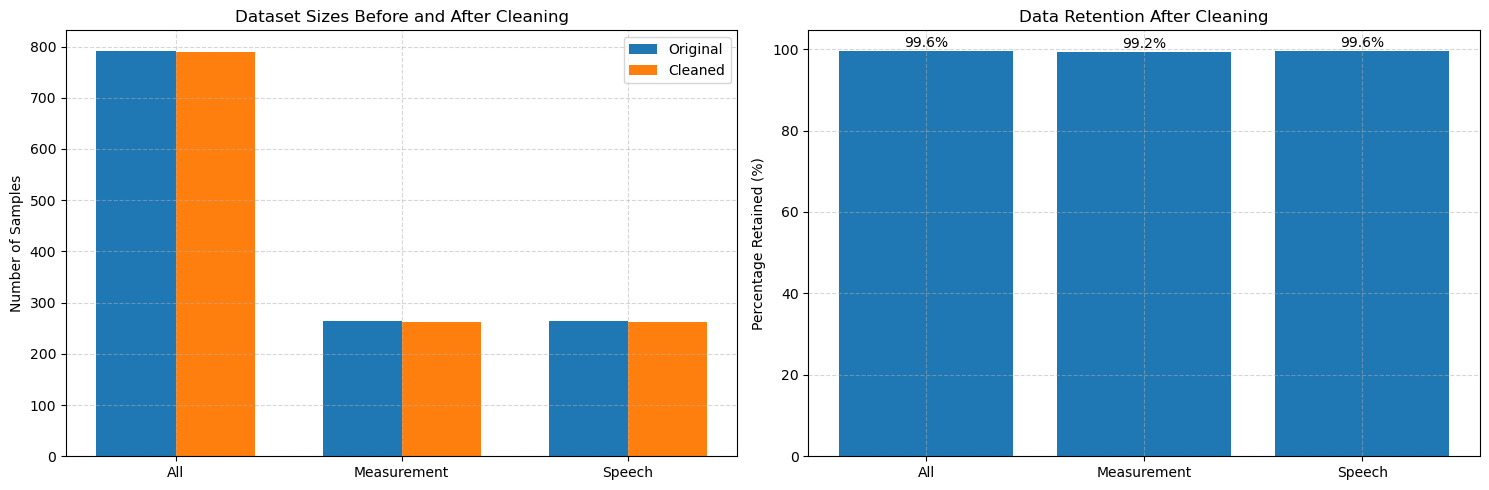

Healthy Signals Before and After Normalization:


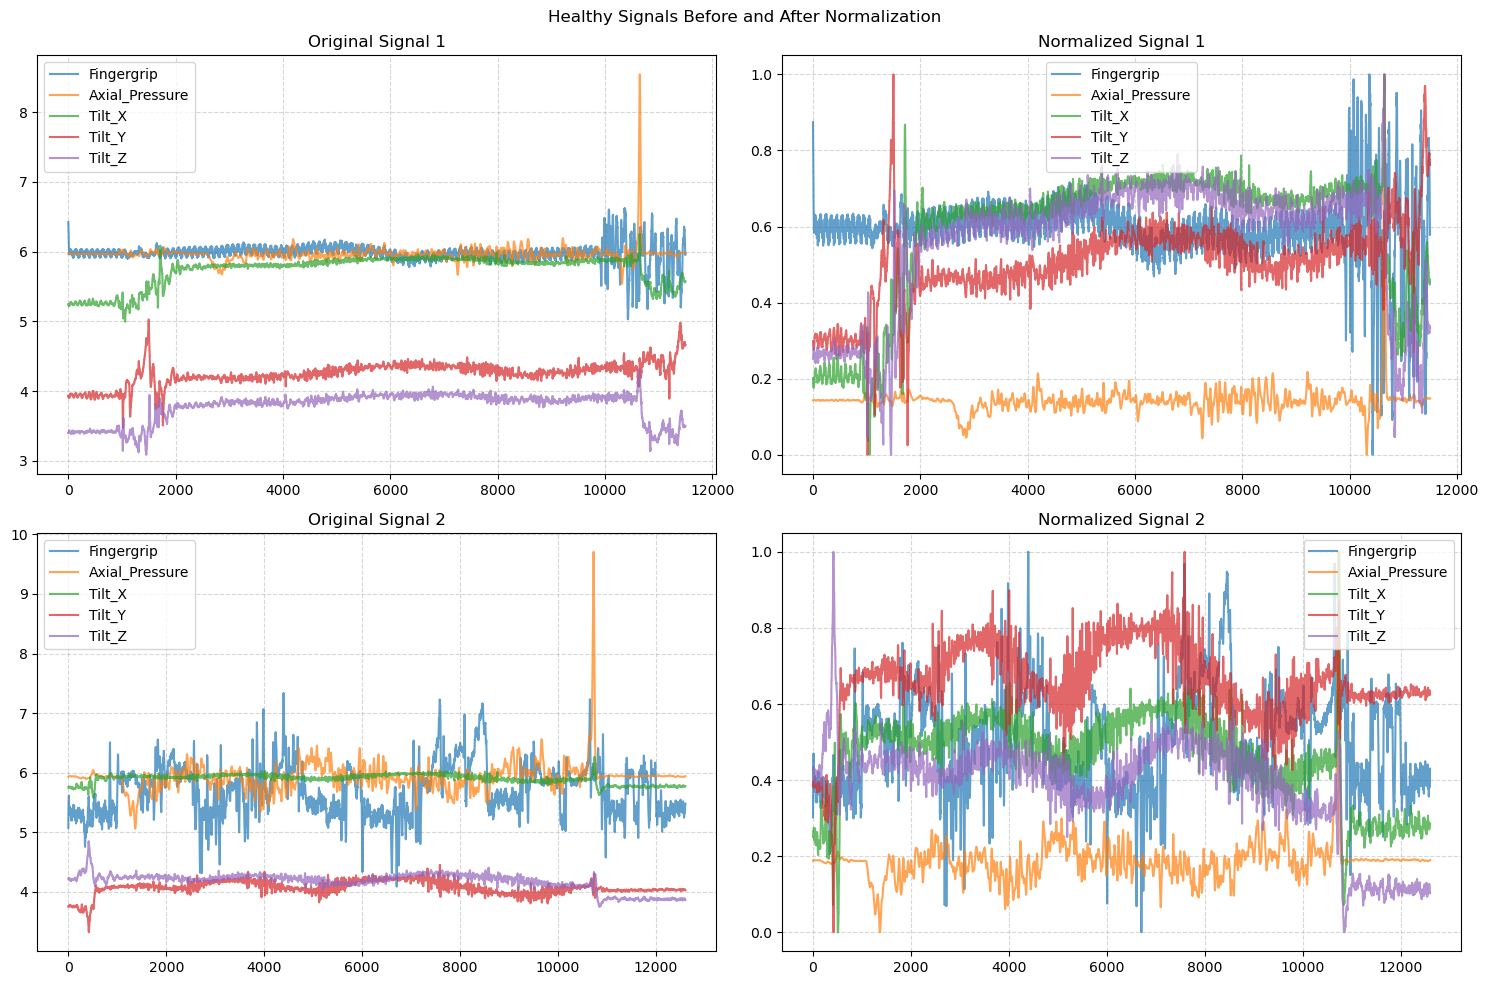


Patient Signals Before and After Normalization:


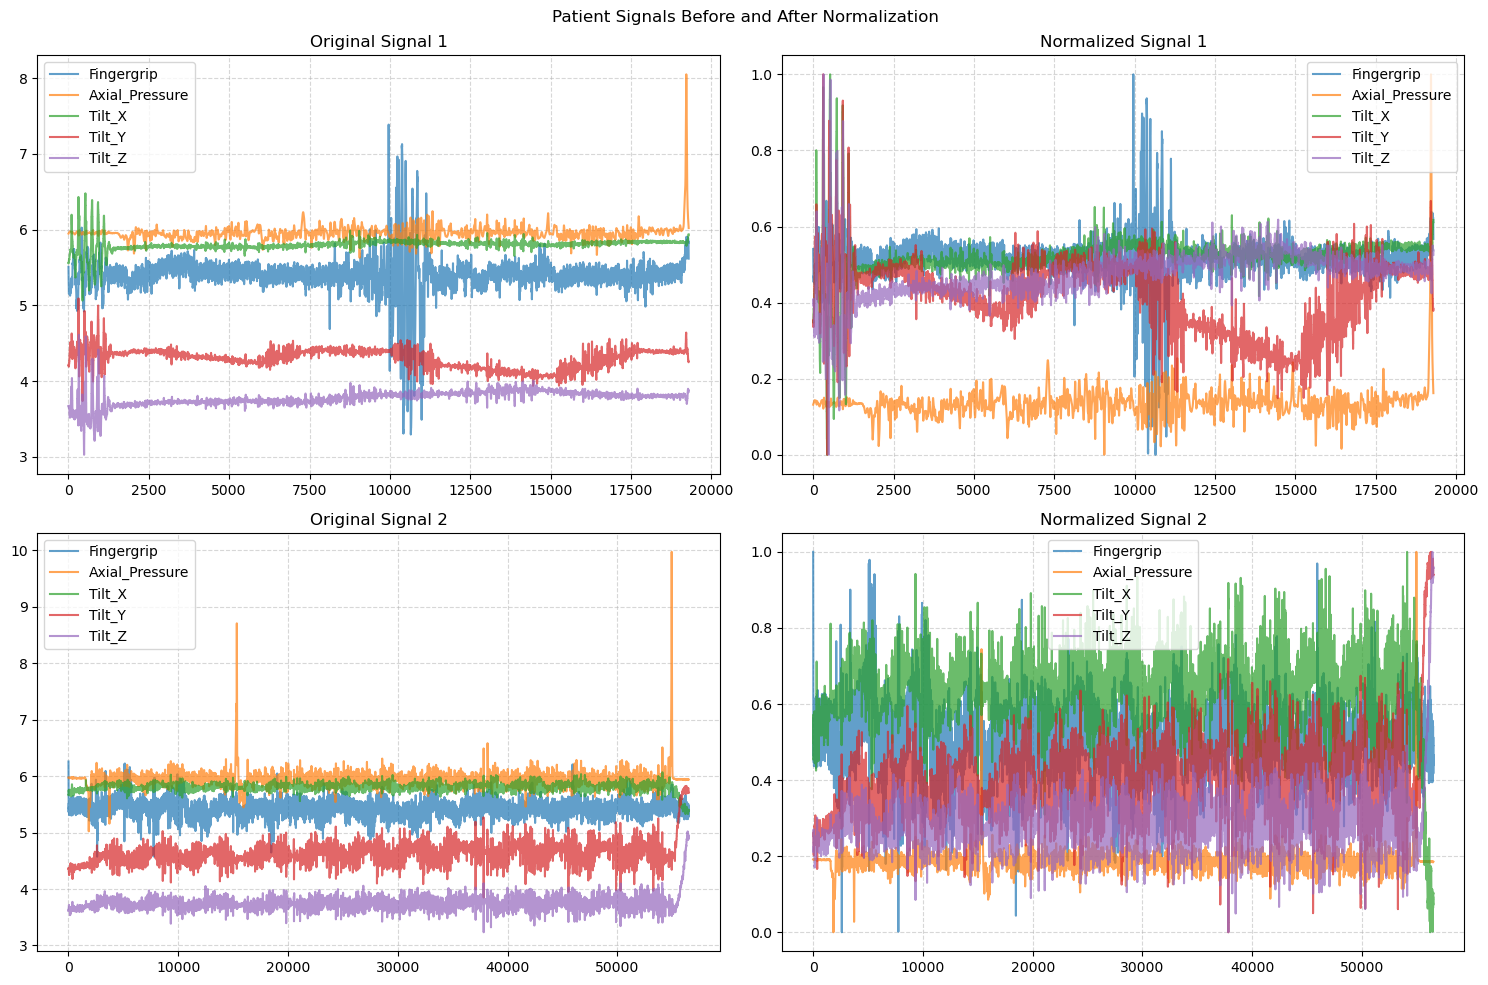

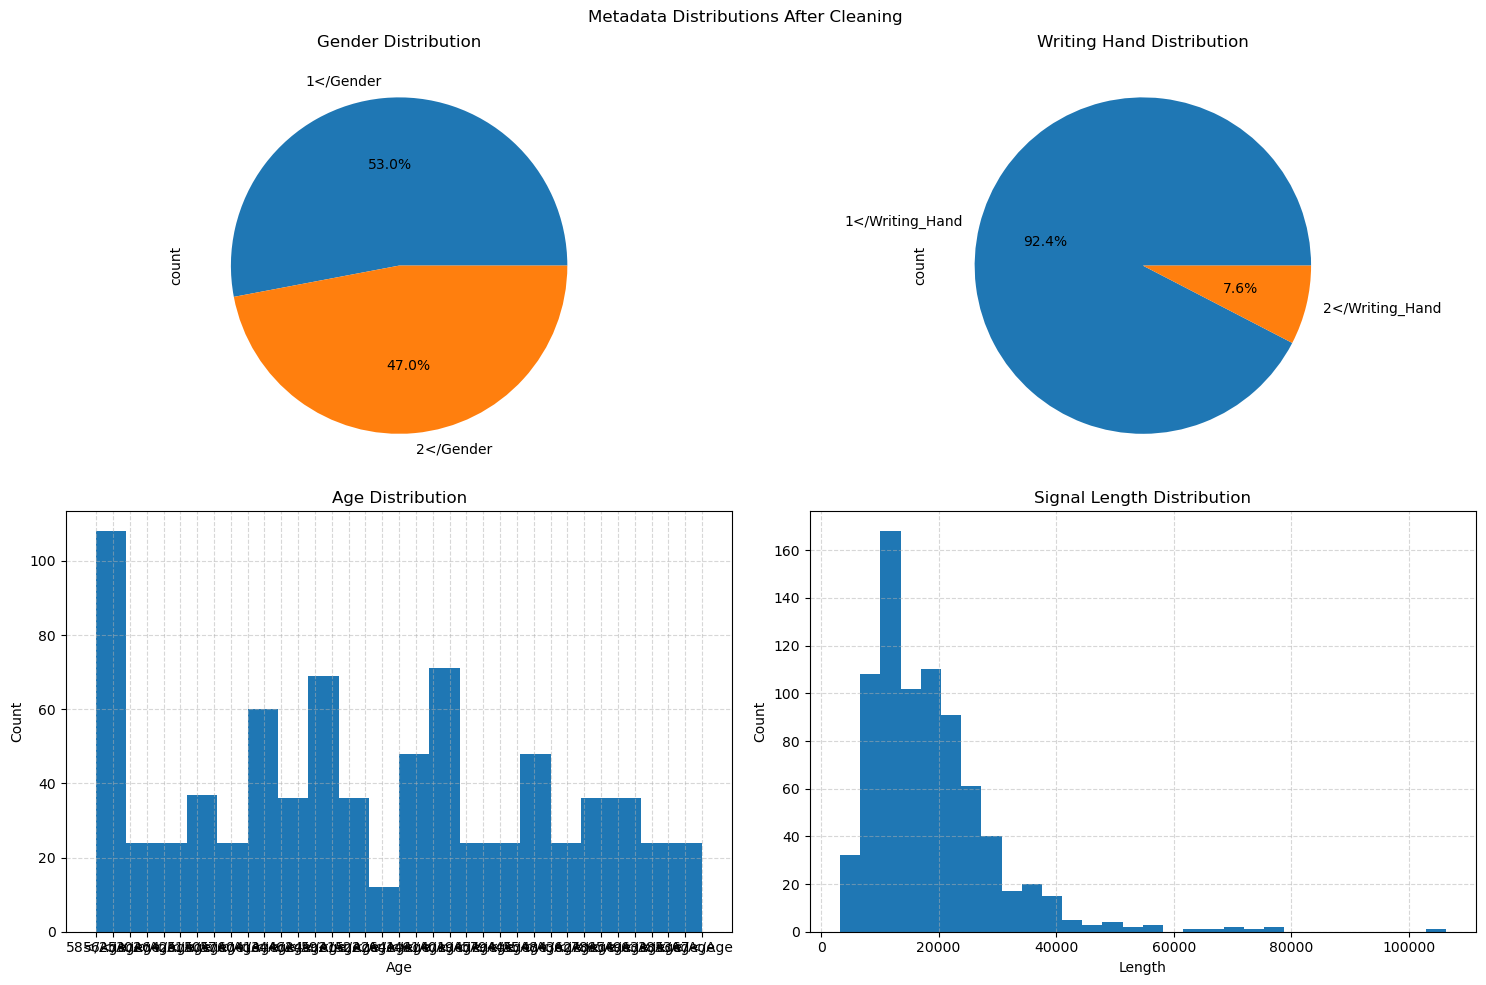

In [8]:
# Visualization of cleaned data
# Set up the plotting style
try:
    import seaborn as sns
    plt.style.use('seaborn')
except (ImportError, OSError):
    # If seaborn style is not available, use a clean default style
    plt.style.use('default')
    plt.rcParams['figure.facecolor'] = 'white'
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.linestyle'] = '--'
    plt.rcParams['grid.alpha'] = 0.5

# 1. Compare original vs cleaned data sizes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Dataset sizes before and after cleaning
datasets = ['All', 'Measurement', 'Speech']
original_sizes = [len(df_all), len(df_sigMea), len(df_sigSp)]
cleaned_sizes = [len(df_all_clean), len(df_sigMea_clean), len(df_sigSp_clean)]

x = np.arange(len(datasets))
width = 0.35

ax1.bar(x - width/2, original_sizes, width, label='Original')
ax1.bar(x + width/2, cleaned_sizes, width, label='Cleaned')
ax1.set_ylabel('Number of Samples')
ax1.set_title('Dataset Sizes Before and After Cleaning')
ax1.set_xticks(x)
ax1.set_xticklabels(datasets)
ax1.legend()

# Percentage of data retained
retention = np.array(cleaned_sizes) / np.array(original_sizes) * 100
ax2.bar(datasets, retention)
ax2.set_ylabel('Percentage Retained (%)')
ax2.set_title('Data Retention After Cleaning')
for i, v in enumerate(retention):
    ax2.text(i, v + 1, f'{v:.1f}%', ha='center')

plt.tight_layout()
plt.show()

# 2. Plot normalized signal examples
def plot_normalized_signals(df_original, df_cleaned, category, num_examples=2):
    fig, axes = plt.subplots(num_examples, 2, figsize=(15, 5*num_examples))
    fig.suptitle(f"{'Patient' if category == 1 else 'Healthy'} Signals Before and After Normalization")
    
    examples = df_cleaned[df_cleaned['label'] == category].sample(n=num_examples)
    for idx, (_, row) in enumerate(examples.iterrows()):
        # Find corresponding original signal
        original = df_original[df_original['file_name'] == row['file_name']].iloc[0]
        
        # Plot original signal
        for i, channel in enumerate(channel_names):
            axes[idx, 0].plot(original['signal'][:, i], label=channel, alpha=0.7)
        axes[idx, 0].set_title(f'Original Signal {idx+1}')
        axes[idx, 0].legend()
        axes[idx, 0].grid(True)
        
        # Plot normalized signal
        for i, channel in enumerate(channel_names):
            axes[idx, 1].plot(row['signal'][:, i], label=channel, alpha=0.7)
        axes[idx, 1].set_title(f'Normalized Signal {idx+1}')
        axes[idx, 1].legend()
        axes[idx, 1].grid(True)
    
    plt.tight_layout()
    plt.show()

print("Healthy Signals Before and After Normalization:")
plot_normalized_signals(df_all, df_all_clean, category=0)
print("\nPatient Signals Before and After Normalization:")
plot_normalized_signals(df_all, df_all_clean, category=1)

# 3. Plot metadata distributions after cleaning
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Metadata Distributions After Cleaning')

# Gender distribution
df_all_clean['Gender'].value_counts().plot(kind='pie', ax=axes[0,0], autopct='%1.1f%%')
axes[0,0].set_title('Gender Distribution')

# Writing Hand distribution
df_all_clean['Writing_Hand'].value_counts().plot(kind='pie', ax=axes[0,1], autopct='%1.1f%%')
axes[0,1].set_title('Writing Hand Distribution')

# Age distribution
df_all_clean['Age'].hist(ax=axes[1,0], bins=20)
axes[1,0].set_title('Age Distribution')
axes[1,0].set_xlabel('Age')
axes[1,0].set_ylabel('Count')

# Signal lengths after cleaning
signal_lengths = df_all_clean['signal'].apply(len)
signal_lengths.hist(ax=axes[1,1], bins=30)
axes[1,1].set_title('Signal Length Distribution')
axes[1,1].set_xlabel('Length')
axes[1,1].set_ylabel('Count')

plt.tight_layout()
plt.show()

# Data Splitting
- **Person-Based Splitting:** Divide the dataset into training, validation, and test sets based on unique person identifiers to prevent data leakage and ensure fair evaluation.
- **Randomization:** Shuffle person IDs before splitting to ensure unbiased distribution across splits.
- **Split Proportions:** Assign approximately 70% of persons to training, 15% to validation, and 15% to test sets for balanced model development and assessment.
- **Leakage Check:** Verify that no person appears in more than one split to maintain strict separation between training and evaluation data."

In [9]:
# Cell 6: Combine sigMea and sigSp DataFrames
df_combined = pd.concat([df_sigMea_clean, df_sigSp_clean], ignore_index=True)
print(f"Combined DataFrame shape: {df_combined.shape}")

Combined DataFrame shape: (525, 7)


In [10]:
# Cell 6.1: Split data by Person_ID_Number
import numpy as np

# Extract unique Person IDs
person_ids = df_combined['Person_ID_Number'].unique()

# Random shuffle of Person IDs
np.random.seed(42) # for reproducibility
np.random.shuffle(person_ids)

# Calculate split indices
train_split_ratio = 0.8
n_ids = len(person_ids)
train_idx = int(train_split_ratio * n_ids)

# Split Person IDs into train and test sets
train_ids = person_ids[:train_idx]
test_ids = person_ids[train_idx:]

# Create DataFrames for each split
df_train = df_combined[df_combined['Person_ID_Number'].isin(train_ids)]
df_test = df_combined[df_combined['Person_ID_Number'].isin(test_ids)]

print("\nData Split Summary:")
print(f"Total number of unique persons: {n_ids}")
print(f"Training set: {len(train_ids)} persons ({len(df_train)} samples)")
print(f"Test set:     {len(test_ids)} persons ({len(df_test)} samples)")

# Verify no data leakage
train_ids_set = set(df_train['Person_ID_Number'].unique())
test_ids_set = set(df_test['Person_ID_Number'].unique())

print("\nChecking for data leakage:")
print(f"Overlap between train and test sets: {len(train_ids_set & test_ids_set)}")


Data Split Summary:
Total number of unique persons: 61
Training set: 48 persons (421 samples)
Test set:     13 persons (104 samples)

Checking for data leakage:
Overlap between train and test sets: 0


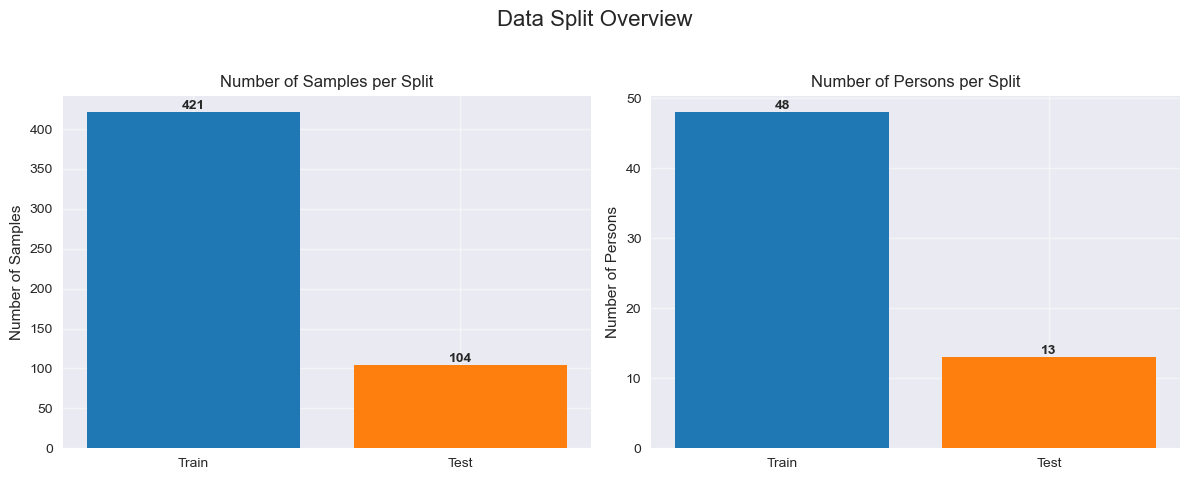

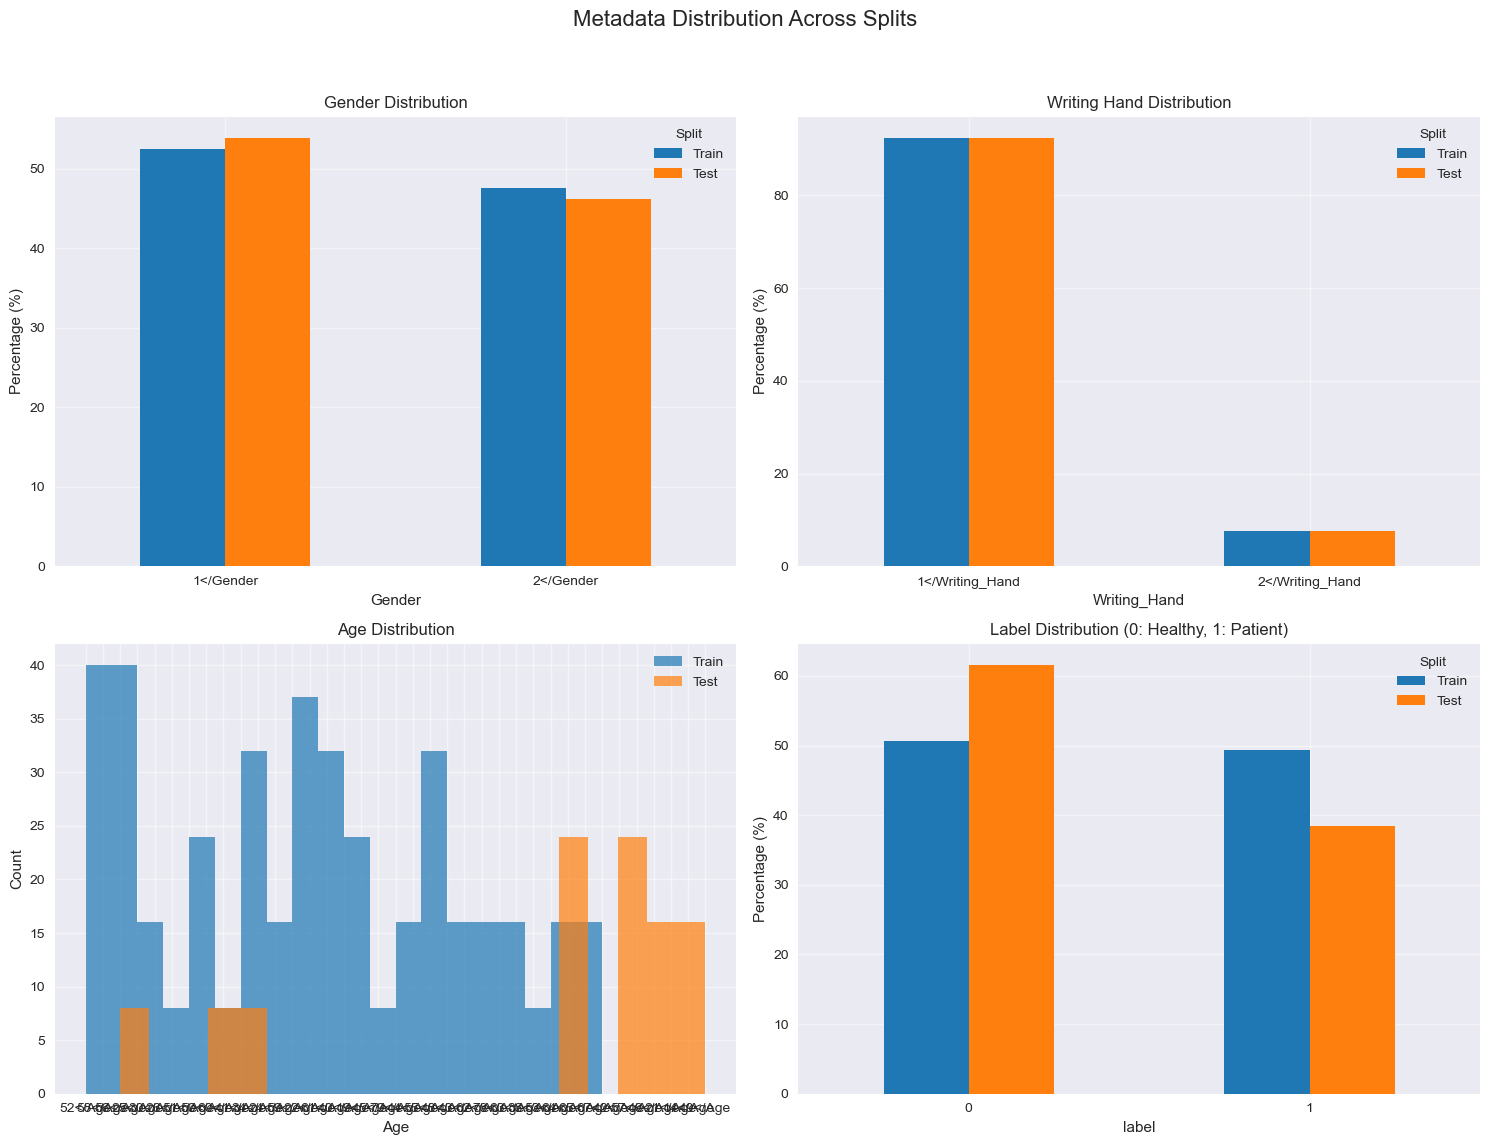

In [11]:
# Visualize data split distributions
# Set up the plotting style
try:
    import seaborn as sns
    import matplotlib.pyplot as plt
    import pandas as pd
    plt.style.use('seaborn-v0_8')
except (ImportError, OSError):
    # If seaborn style is not available, use a clean default style
    import matplotlib.pyplot as plt
    import pandas as pd
    plt.style.use('default')
    plt.rcParams['figure.facecolor'] = 'white'
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.linestyle'] = '--'
    plt.rcParams['grid.alpha'] = 0.5


# 1. Sample distribution across splits
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Data Split Overview', fontsize=16)

# Number of samples per split
splits = ['Train', 'Test']
samples = [len(df_train), len(df_test)]
persons = [len(train_ids), len(test_ids)]

ax1.bar(splits, samples, color=['#1f77b4', '#ff7f0e'])
ax1.set_title('Number of Samples per Split')
ax1.set_ylabel('Number of Samples')
for i, v in enumerate(samples):
    ax1.text(i, v + max(samples)*0.01, str(v), ha='center', fontweight='bold')

ax2.bar(splits, persons, color=['#1f77b4', '#ff7f0e'])
ax2.set_title('Number of Persons per Split')
ax2.set_ylabel('Number of Persons')
for i, v in enumerate(persons):
    ax2.text(i, v + max(persons)*0.01, str(v), ha='center', fontweight='bold')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# 2. Metadata distribution across splits
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Metadata Distribution Across Splits', fontsize=16)

# Gender distribution
gender_dist = pd.DataFrame({
    'Train': df_train['Gender'].value_counts(normalize=True),
    'Test': df_test['Gender'].value_counts(normalize=True)
}) * 100

gender_dist.plot(kind='bar', ax=axes[0,0], color=['#1f77b4', '#ff7f0e'])
axes[0,0].set_title('Gender Distribution')
axes[0,0].set_ylabel('Percentage (%)')
axes[0,0].tick_params(axis='x', rotation=0)
axes[0,0].legend(title='Split')

# Writing Hand distribution
hand_dist = pd.DataFrame({
    'Train': df_train['Writing_Hand'].value_counts(normalize=True),
    'Test': df_test['Writing_Hand'].value_counts(normalize=True)
}) * 100

hand_dist.plot(kind='bar', ax=axes[0,1], color=['#1f77b4', '#ff7f0e'])
axes[0,1].set_title('Writing Hand Distribution')
axes[0,1].set_ylabel('Percentage (%)')
axes[0,1].tick_params(axis='x', rotation=0)
axes[0,1].legend(title='Split')

# Age distribution
df_train['Age'].hist(ax=axes[1,0], alpha=0.7, label='Train', bins=20, color='#1f77b4')
df_test['Age'].hist(ax=axes[1,0], alpha=0.7, label='Test', bins=20, color='#ff7f0e')
axes[1,0].set_title('Age Distribution')
axes[1,0].set_xlabel('Age')
axes[1,0].set_ylabel('Count')
axes[1,0].legend()

# Label distribution
label_dist = pd.DataFrame({
    'Train': df_train['label'].value_counts(normalize=True),
    'Test': df_test['label'].value_counts(normalize=True)
}) * 100

label_dist.plot(kind='bar', ax=axes[1,1], color=['#1f77b4', '#ff7f0e'])
axes[1,1].set_title('Label Distribution (0: Healthy, 1: Patient)')
axes[1,1].set_ylabel('Percentage (%)')
axes[1,1].tick_params(axis='x', rotation=0)
axes[1,1].legend(title='Split')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Data Augmentation
- **Jittering (Gaussian Noise):** 
  - Add random Gaussian noise to signals to simulate sensor noise and improve robustness
  - Noise level controlled through standard deviation parameter (0.005 to 0.02)
  - Applied only to training data to maintain validation/test integrity
- **Time Warping:** 
  - Randomly stretch or compress signal segments to simulate speed variations
  - Uses cubic spline interpolation for smooth warping
  - Warping factor range: 0.8 to 1.2 (±20% time variation)
  - Applied only to training data to prevent data leakage

Signal duration statistics:
Mean duration: 17209.26
Median duration: 14500.00
Standard deviation: 10183.19
Target duration: 14500
Short threshold: 9408.41
Long threshold: 19591.59

Applying data augmentation to training set...


100%|██████████| 421/421 [00:07<00:00, 53.01it/s]



Augmentation Statistics:
Final training set size: 1189 signals
Original signals: 421
Augmented signals: 768

Duration Statistics:
Original mean duration: 17209.26
Original std duration: 10183.19
Final mean duration: 14335.83
Final std duration: 6905.11


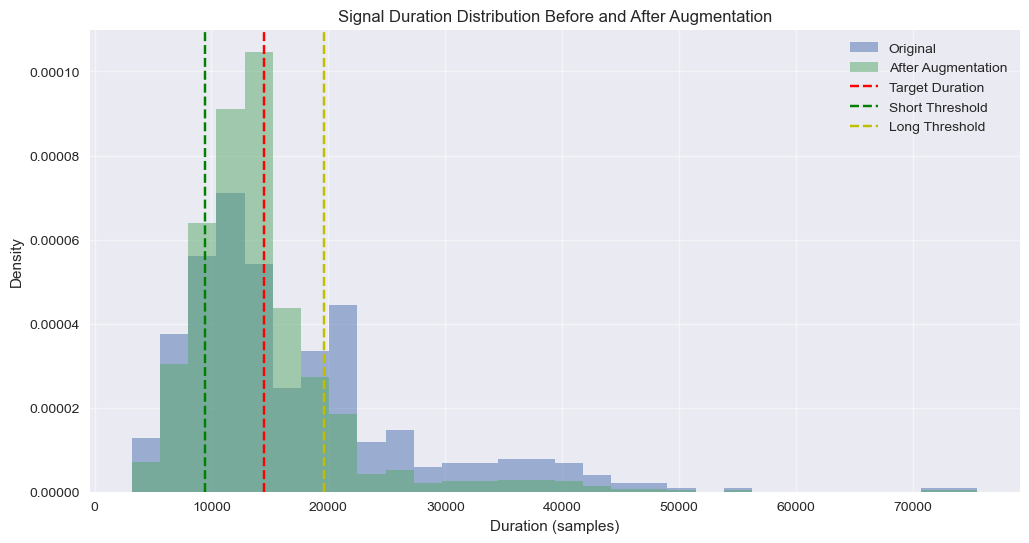

In [12]:
# Data Augmentation Functions
import scipy.interpolate as interp
import numpy as np

def apply_jitter(signal, noise_level=0.01):
    """Add Gaussian noise to the signal"""
    noise = np.random.normal(0, noise_level, signal.shape)
    return signal + noise

def apply_time_warp(signal, target_length=None, warp_factor_range=(0.8, 1.2)):
    """
    Apply time warping to the signal with option to target a specific length
    If target_length is provided, warps signal to approximately that length
    Otherwise uses random warping factor from warp_factor_range
    """
    orig_len = len(signal)
    
    if target_length is not None:
        # Calculate warping factor to achieve target length
        warp_factor = target_length / orig_len
        # Add small random variation (±5%) to avoid identical lengths
        warp_factor *= np.random.uniform(0.95, 1.05)
    else:
        warp_factor = np.random.uniform(*warp_factor_range)
    
    new_len = int(orig_len * warp_factor)
    
    # Create warped time points
    old_time = np.arange(orig_len)
    new_time = np.linspace(0, orig_len-1, new_len)
    
    # Apply warping to each channel
    warped_signal = np.zeros((new_len, signal.shape[1]))
    for i in range(signal.shape[1]):
        interpolator = interp.CubicSpline(old_time, signal[:, i])
        warped_signal[:, i] = interpolator(new_time)
    
    # Resample back to original length if not targeting specific length
    if target_length is None:
        final_time = np.linspace(0, new_len-1, orig_len)
        final_signal = np.zeros((orig_len, signal.shape[1]))
        for i in range(signal.shape[1]):
            interpolator = interp.CubicSpline(new_time, warped_signal[:, i])
            final_signal[:, i] = interpolator(final_time)
        return final_signal
    
    return warped_signal

# Calculate duration statistics for adaptive augmentation
signal_durations = df_train['signal'].apply(len)
mean_duration = signal_durations.mean()
median_duration = signal_durations.median()
std_duration = signal_durations.std()
target_duration = int(median_duration)  # Use median as target to reduce impact of outliers

# Group signals by length categories
short_threshold = median_duration - 0.5 * std_duration
long_threshold = median_duration + 0.5 * std_duration

print(f"Signal duration statistics:")
print(f"Mean duration: {mean_duration:.2f}")
print(f"Median duration: {median_duration:.2f}")
print(f"Standard deviation: {std_duration:.2f}")
print(f"Target duration: {target_duration}")
print(f"Short threshold: {short_threshold:.2f}")
print(f"Long threshold: {long_threshold:.2f}")

# Apply augmentation to training data only
augmented_records = []
original_records = []
print("\nApplying data augmentation to training set...")

# Keep original records and mark them as not augmented
for record in df_train.to_dict('records'):
    record['augmented'] = False
    original_records.append(record)

# Create augmented versions with adaptive time warping
for idx, row in tqdm(df_train.iterrows(), total=len(df_train)):
    original_signal = row['signal']
    signal_length = len(original_signal)
    
    # Determine signal category and augmentation strategy
    if signal_length < short_threshold:
        # Short signals: create 2-3 variations with slight stretching
        n_augmentations = 2
        target_lengths = [
            int(signal_length * np.random.uniform(1.1, 1.3))
            for _ in range(n_augmentations)
        ]
    elif signal_length > long_threshold:
        # Long signals: create 2-3 compressed versions targeting median length
        n_augmentations = min(3, int(signal_length / median_duration))
        target_lengths = [
            int(target_duration * np.random.uniform(0.9, 1.1))
            for _ in range(n_augmentations)
        ]
    else:
        # Medium signals: create 2 variations with modest warping
        n_augmentations = 2
        target_lengths = [
            int(signal_length * np.random.uniform(0.9, 1.1))
            for _ in range(n_augmentations)
        ]
    
    for i, target_length in enumerate(target_lengths):
        new_record = row.copy()
        augmented_signal = original_signal.copy()
        
        # Apply jittering with random noise level
        noise_level = np.random.uniform(0.005, 0.02)
        augmented_signal = apply_jitter(augmented_signal, noise_level)
        
        # Apply time warping with target length
        augmented_signal = apply_time_warp(augmented_signal, target_length=target_length)
        
        # Update signal and mark as augmented
        new_record['signal'] = augmented_signal
        new_record['augmented'] = True
        new_record['original_duration'] = signal_length
        new_record['target_duration'] = target_length
        augmented_records.append(new_record)

# Combine original and augmented records
all_records = original_records + augmented_records

# Create new DataFrame with original and augmented data
df_train = pd.DataFrame(all_records)

# Print statistics about the augmentation
print("\nAugmentation Statistics:")
print(f"Final training set size: {len(df_train)} signals")
print(f"Original signals: {len(df_train[df_train['augmented'] == False])}")
print(f"Augmented signals: {len(df_train[df_train['augmented'] == True])}")

# Calculate and print duration statistics
final_durations = df_train['signal'].apply(len)
print("\nDuration Statistics:")
print(f"Original mean duration: {mean_duration:.2f}")
print(f"Original std duration: {std_duration:.2f}")
print(f"Final mean duration: {final_durations.mean():.2f}")
print(f"Final std duration: {final_durations.std():.2f}")

# Plot duration distribution before and after augmentation
plt.figure(figsize=(12, 6))
plt.hist(signal_durations, bins=30, alpha=0.5, label='Original', density=True)
plt.hist(final_durations, bins=30, alpha=0.5, label='After Augmentation', density=True)
plt.axvline(median_duration, color='r', linestyle='--', label='Target Duration')
plt.axvline(short_threshold, color='g', linestyle='--', label='Short Threshold')
plt.axvline(long_threshold, color='y', linestyle='--', label='Long Threshold')
plt.title('Signal Duration Distribution Before and After Augmentation')
plt.xlabel('Duration (samples)')
plt.ylabel('Density')
plt.legend()
plt.show()

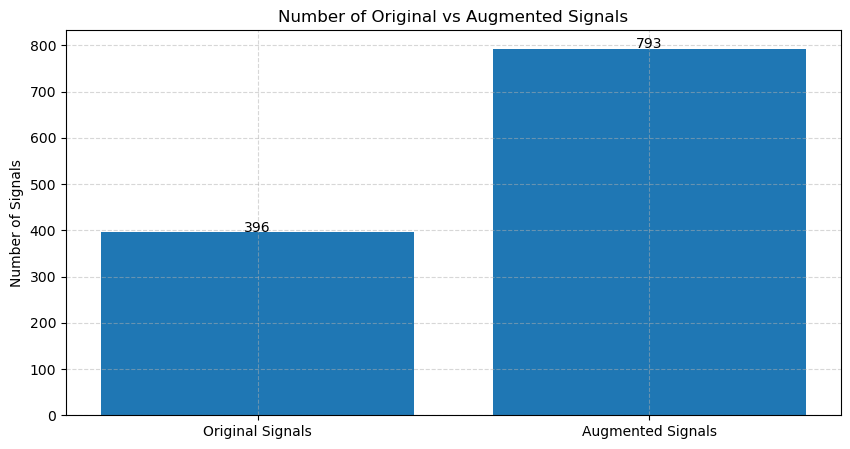

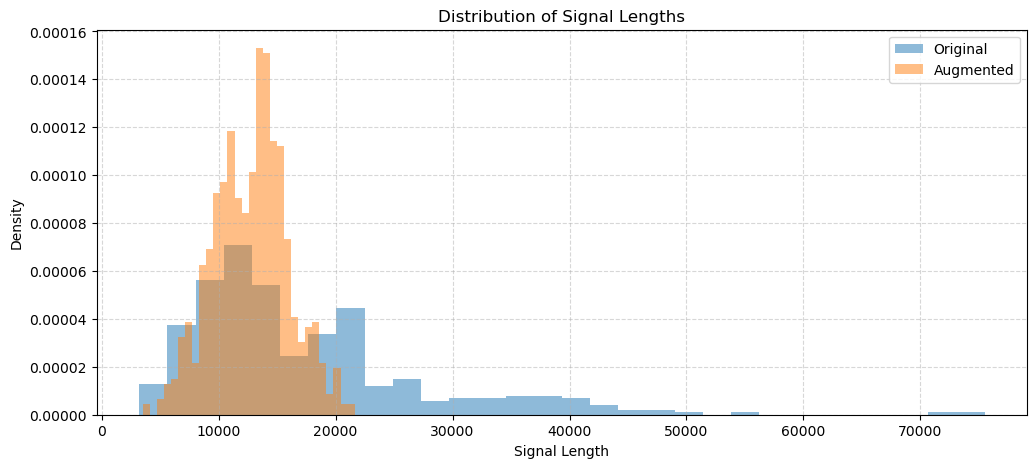

Examples of Original vs Augmented Signals:


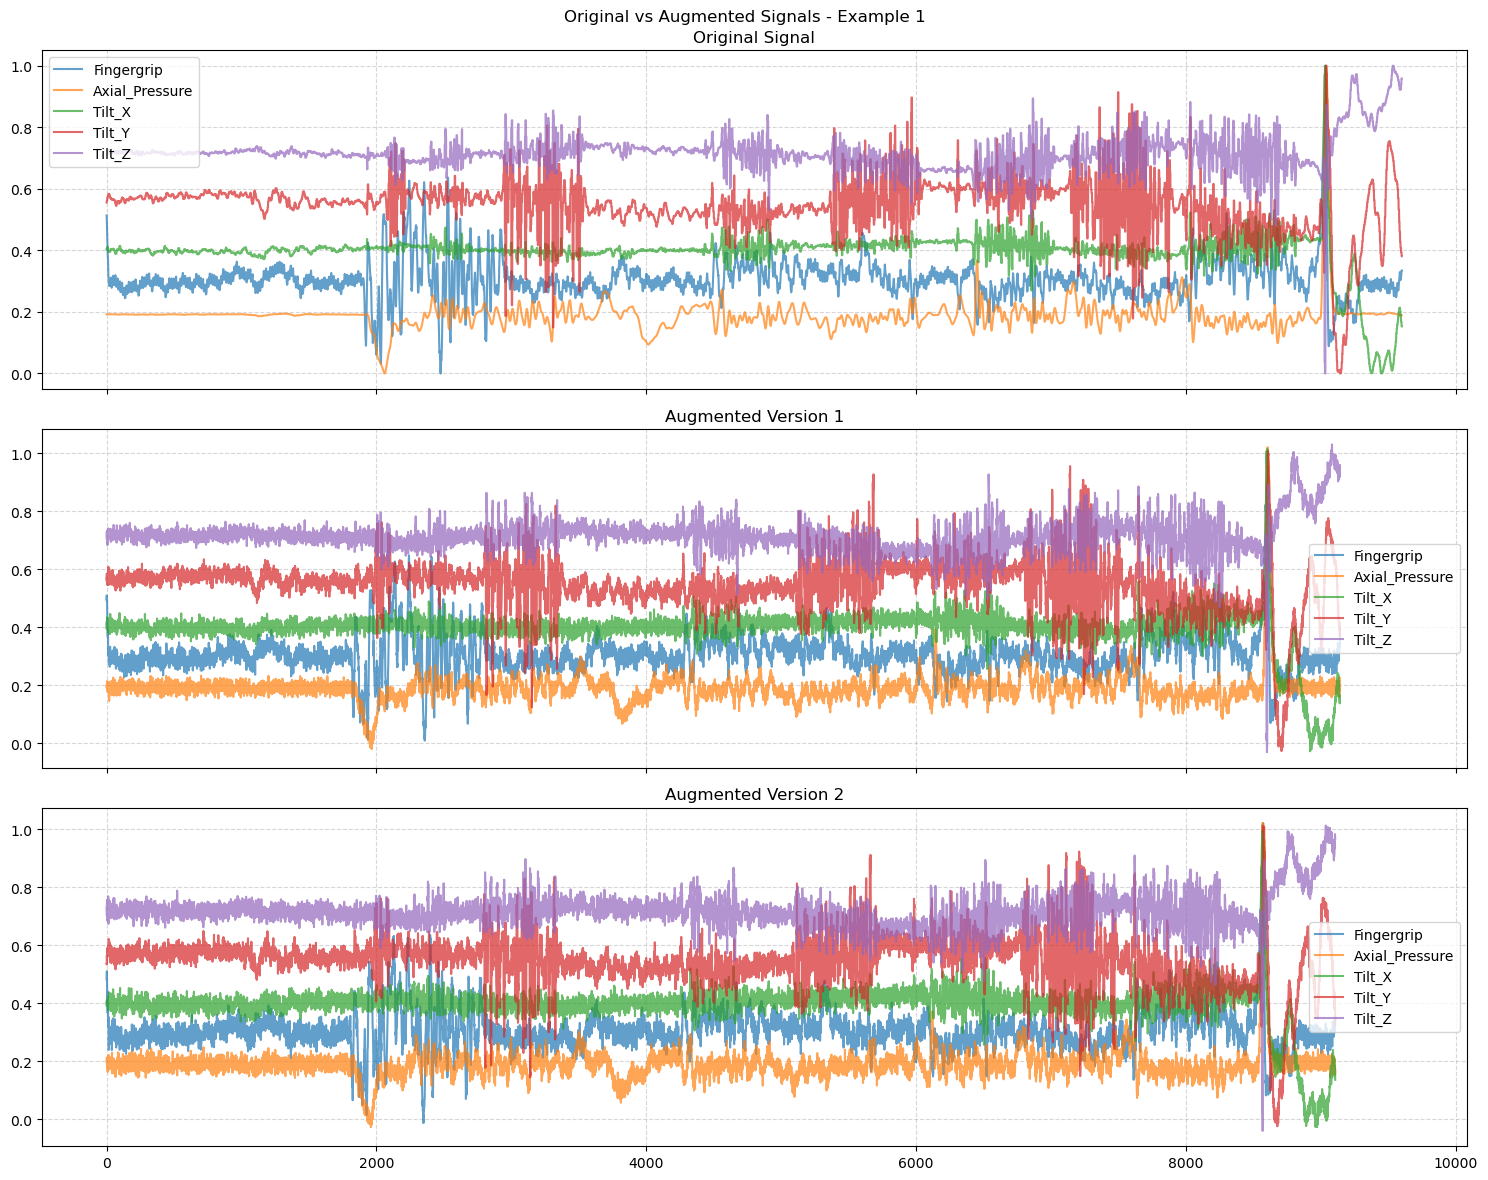

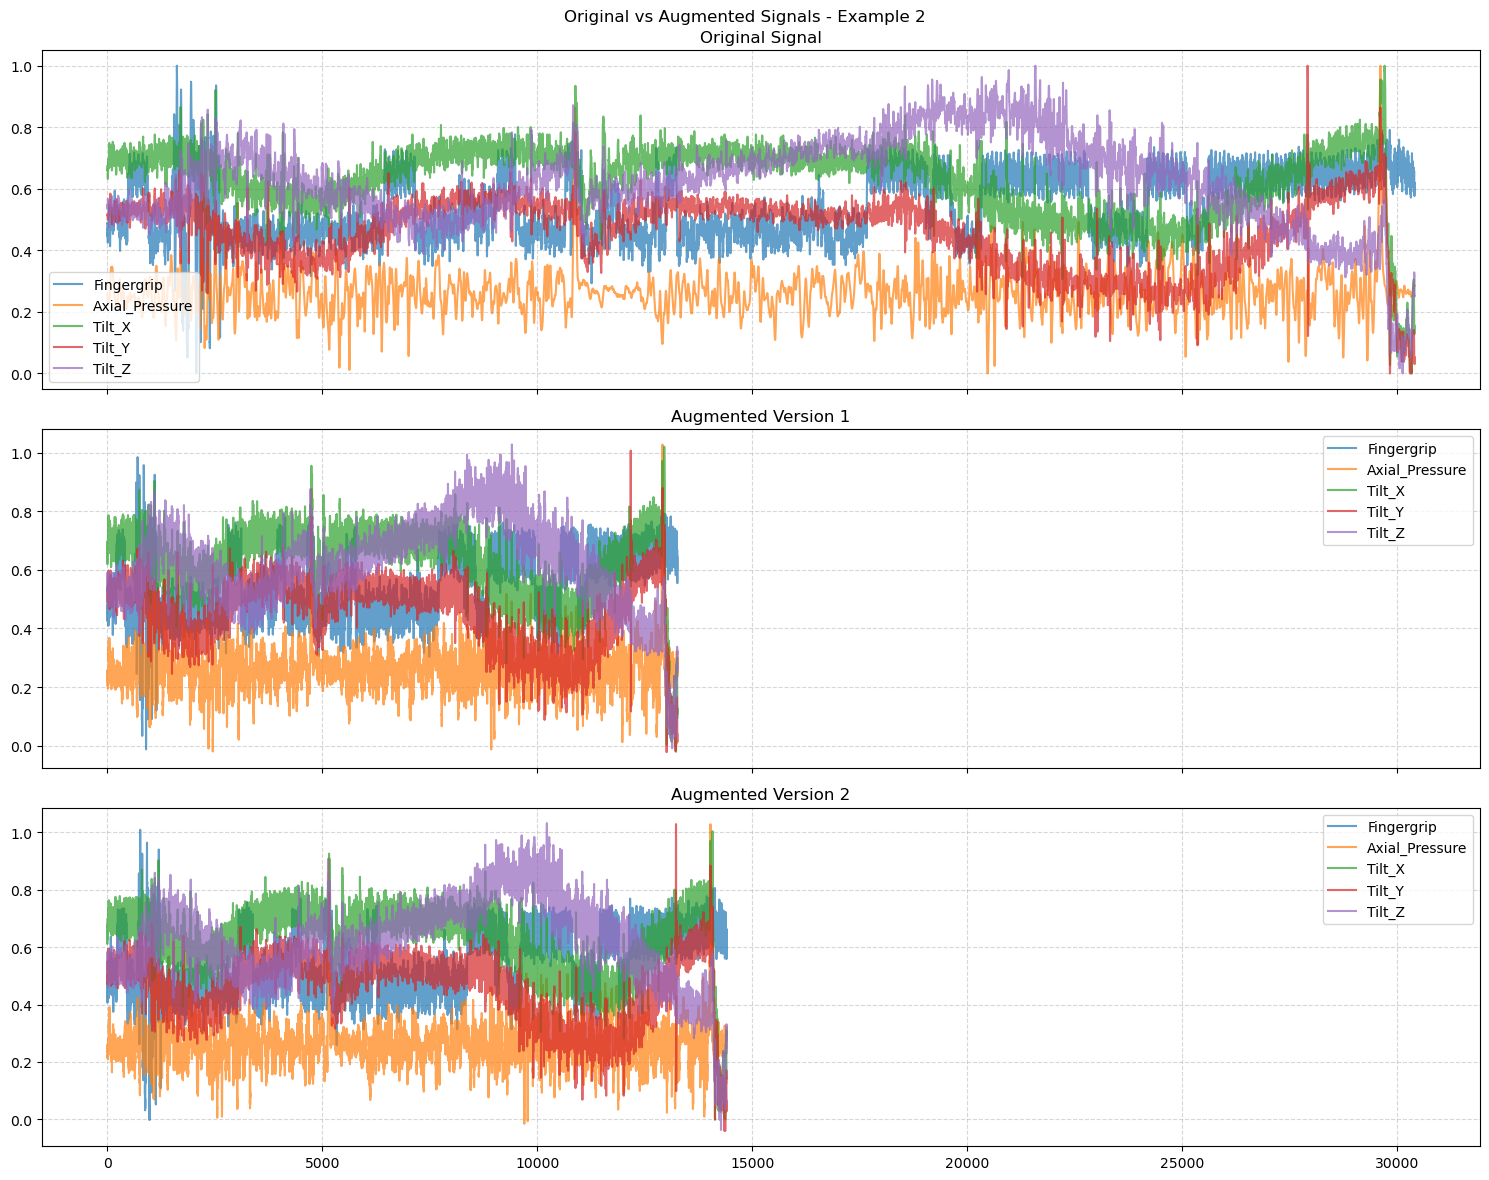

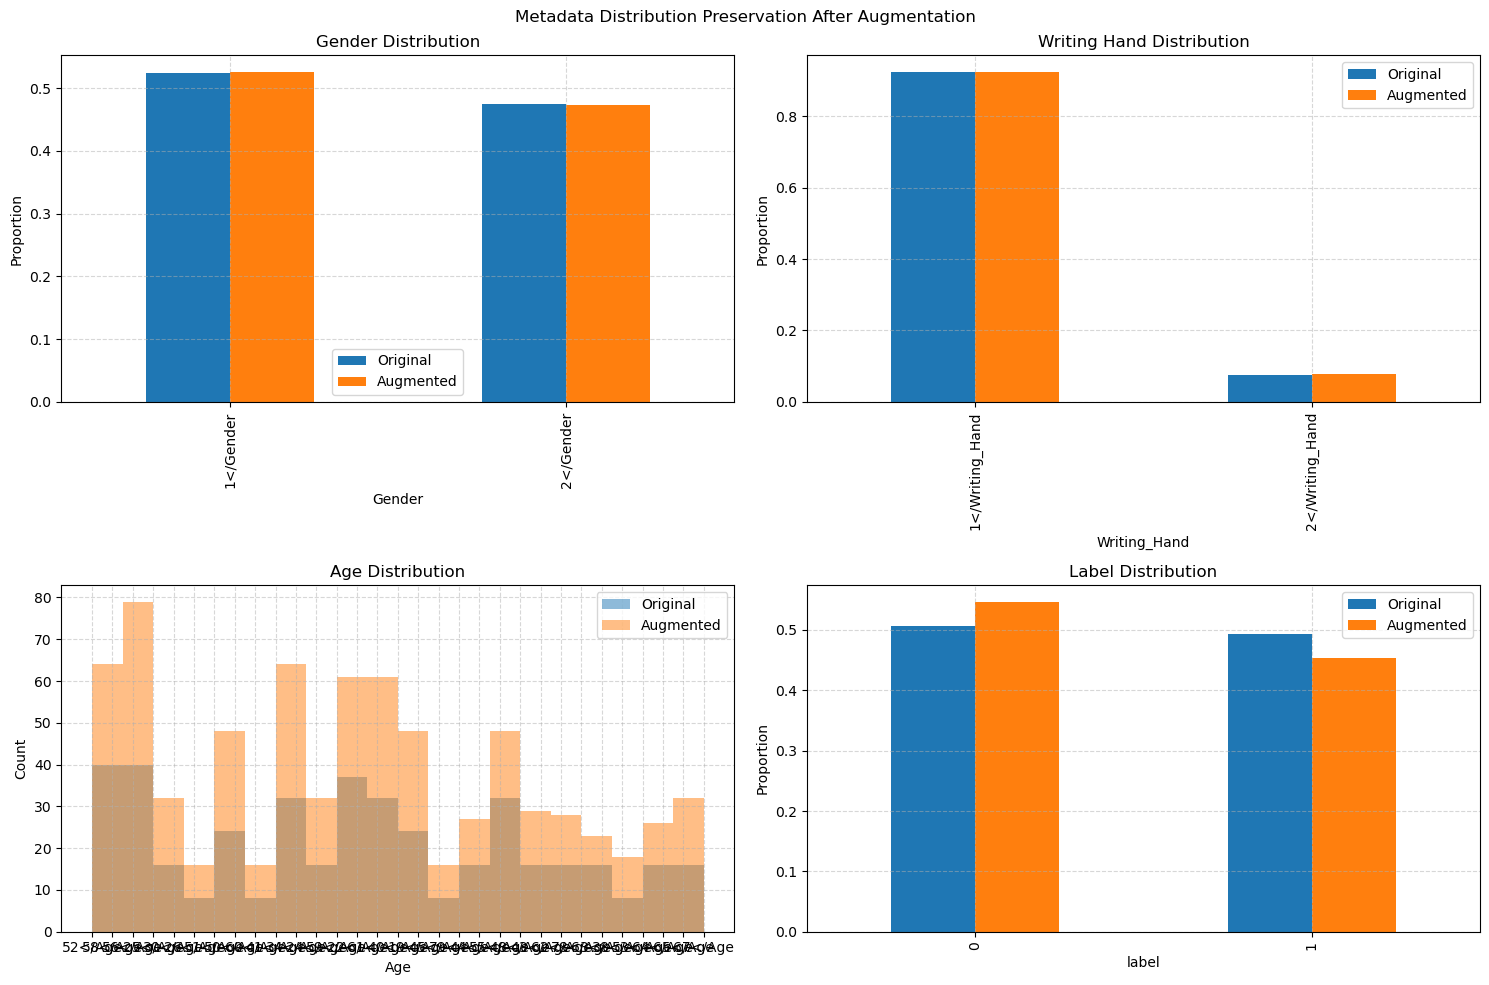

In [13]:
# Visualize augmentation effects
# Set up the plotting style
try:
    import seaborn as sns
    plt.style.use('seaborn')
except (ImportError, OSError):
    # If seaborn style is not available, use a clean default style
    plt.style.use('default')
    plt.rcParams['figure.facecolor'] = 'white'
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.linestyle'] = '--'
    plt.rcParams['grid.alpha'] = 0.5


# 1. Compare signal counts before and after augmentation
plt.figure(figsize=(10, 5))
counts = [len(df_train) // (n_augmentations + 1), 
         len(df_train) - len(df_train) // (n_augmentations + 1)]
plt.bar(['Original Signals', 'Augmented Signals'], counts)
plt.title('Number of Original vs Augmented Signals')
plt.ylabel('Number of Signals')
for i, v in enumerate(counts):
    plt.text(i, v + 1, str(v), ha='center')
plt.show()

# 2. Compare signal lengths distribution
plt.figure(figsize=(12, 5))
original_lengths = df_train[~df_train['augmented']]['signal'].apply(len)
augmented_lengths = df_train[df_train['augmented']]['signal'].apply(len)

plt.hist(original_lengths, bins=30, alpha=0.5, label='Original', density=True)
plt.hist(augmented_lengths, bins=30, alpha=0.5, label='Augmented', density=True)
plt.title('Distribution of Signal Lengths')
plt.xlabel('Signal Length')
plt.ylabel('Density')
plt.legend()
plt.show()

# 3. Example of original vs augmented signals
def plot_augmentation_example(df, num_examples=2):
    original_samples = df[~df['augmented']].sample(n=num_examples)
    
    for idx, (_, orig_row) in enumerate(original_samples.iterrows()):
        # Find corresponding augmented versions
        augmented = df[
            (df['augmented']) & 
            (df['file_name'] == orig_row['file_name'])
        ]
        
        fig, axes = plt.subplots(1 + len(augmented), 1, 
                                figsize=(15, 4*(1 + len(augmented))),
                                sharex=True)
        fig.suptitle(f'Original vs Augmented Signals - Example {idx+1}')
        
        # Plot original signal
        for i, channel in enumerate(channel_names):
            axes[0].plot(orig_row['signal'][:, i], label=channel, alpha=0.7)
        axes[0].set_title('Original Signal')
        axes[0].legend()
        axes[0].grid(True)
        
        # Plot augmented versions
        for aug_idx, (_, aug_row) in enumerate(augmented.iterrows(), 1):
            for i, channel in enumerate(channel_names):
                axes[aug_idx].plot(aug_row['signal'][:, i], label=channel, alpha=0.7)
            axes[aug_idx].set_title(f'Augmented Version {aug_idx}')
            axes[aug_idx].legend()
            axes[aug_idx].grid(True)
        
        plt.tight_layout()
        plt.show()

print("Examples of Original vs Augmented Signals:")
plot_augmentation_example(df_train)

# 4. Metadata preservation check
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Metadata Distribution Preservation After Augmentation')

# Original data
original_data = df_train[~df_train['augmented']]
augmented_data = df_train[df_train['augmented']]

# Gender distribution
pd.DataFrame({
    'Original': original_data['Gender'].value_counts(normalize=True),
    'Augmented': augmented_data['Gender'].value_counts(normalize=True)
}).plot(kind='bar', ax=axes[0,0])
axes[0,0].set_title('Gender Distribution')
axes[0,0].set_ylabel('Proportion')

# Writing Hand distribution
pd.DataFrame({
    'Original': original_data['Writing_Hand'].value_counts(normalize=True),
    'Augmented': augmented_data['Writing_Hand'].value_counts(normalize=True)
}).plot(kind='bar', ax=axes[0,1])
axes[0,1].set_title('Writing Hand Distribution')
axes[0,1].set_ylabel('Proportion')

# Age distribution
original_data['Age'].hist(ax=axes[1,0], alpha=0.5, label='Original', bins=20)
augmented_data['Age'].hist(ax=axes[1,0], alpha=0.5, label='Augmented', bins=20)
axes[1,0].set_title('Age Distribution')
axes[1,0].set_xlabel('Age')
axes[1,0].set_ylabel('Count')
axes[1,0].legend()

# Label distribution
pd.DataFrame({
    'Original': original_data['label'].value_counts(normalize=True),
    'Augmented': augmented_data['label'].value_counts(normalize=True)
}).plot(kind='bar', ax=axes[1,1])
axes[1,1].set_title('Label Distribution')
axes[1,1].set_ylabel('Proportion')

plt.tight_layout()
plt.show()

# Feature Engineering
- **Statistical Features:** Compute basic statistics (mean, standard deviation, min, max, range, median) for each signal channel to capture essential characteristics of the data.
- **Derivative Features:** Calculate first and second derivatives (jerk and snap) of the signals to quantify dynamic changes and motion patterns.
- **Sliding Window Segmentation:** Segment each signal into overlapping windows to extract localized features, improving the model's ability to detect temporal patterns.
- **Delta Features:** Compute the change (delta) in feature values between consecutive windows for each file, capturing transitions and trends within the signal.

In [14]:
# Cell 7: Simplified Feature extraction helpers
def compute_basic_stats(signal):
    """Compute only basic statistics without entropy or zero crossings"""
    return {
        "mean": np.mean(signal),
        "std": np.std(signal),
        "min": np.min(signal),
        "max": np.max(signal),
        "range": np.max(signal) - np.min(signal),
        "median": np.median(signal),
    }

def compute_derivatives(signal, order=1, sampling_rate=1000):
    """Compute derivatives up to snap (2nd derivative)"""
    dt = 1 / sampling_rate
    derivative = signal.copy()
    for _ in range(order):
        derivative = np.gradient(derivative, dt)
    return derivative

def compute_mass(signal):
    """Compute motion mass (sum of absolute values)"""
    return np.sum(np.abs(signal))

def extract_features_from_window(window_data, sampling_rate=1000):
    """Simplified feature extraction without entropy or zero crossings"""
    features = {}
    
    for i, channel in enumerate(channel_names):
        signal = window_data[:, i]
        stats = compute_basic_stats(signal)
        for stat_name, stat_val in stats.items():
            features[f"{channel}_{stat_name}"] = stat_val

        # First and second derivatives
        jerk = compute_derivatives(signal, order=1, sampling_rate=sampling_rate)
        snap = compute_derivatives(signal, order=2, sampling_rate=sampling_rate)

        # Only mass features
        features[f"{channel}_jerk_mass"] = compute_mass(jerk)
        features[f"{channel}_snap_mass"] = compute_mass(snap)

    return features

In [15]:
# Cell 8: Enhanced Sliding window feature extraction with metadata
window_size = 1000  # 1 second
step_size = 500     # 50% overlap
sampling_rate = 1000

def extract_features_from_df(df):
    features = []
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        signal = row["signal"]
        label = row["label"]
        file_name = row["file_name"]
        
        # Get all metadata columns (excluding signal, label, and file_name)
        metadata = {k: v for k, v in row.items() 
                   if k not in ['signal', 'label', 'file_name']}

        if signal.shape[0] < window_size:
            continue  # Skip very short signals

        for start in range(0, signal.shape[0] - window_size + 1, step_size):
            end = start + window_size
            window_data = signal[start:end, :]

            window_features = extract_features_from_window(window_data, sampling_rate)
            window_features["label"] = label
            window_features["file_name"] = file_name
            window_features["start_index"] = start
            window_features["end_index"] = end
            
            # Add all metadata to the window features
            window_features.update(metadata)

            features.append(window_features)
    
    return pd.DataFrame(features)

# Extract features for each split
print("Extracting features for training set...")
df_features_train = extract_features_from_df(df_train)
print("Extracting features for test set...")
df_features_test = extract_features_from_df(df_test)

print("\nFeature extraction complete:")
print(f"Training set shape: {df_features_train.shape}")
print(f"Test set shape: {df_features_test.shape}")

Extracting features for training set...


100%|██████████| 1189/1189 [00:30<00:00, 39.07it/s]


Extracting features for test set...


100%|██████████| 104/104 [00:03<00:00, 32.81it/s]


Feature extraction complete:
Training set shape: (32376, 51)
Test set shape: (2960, 48)


Feature Correlations in Training Set:


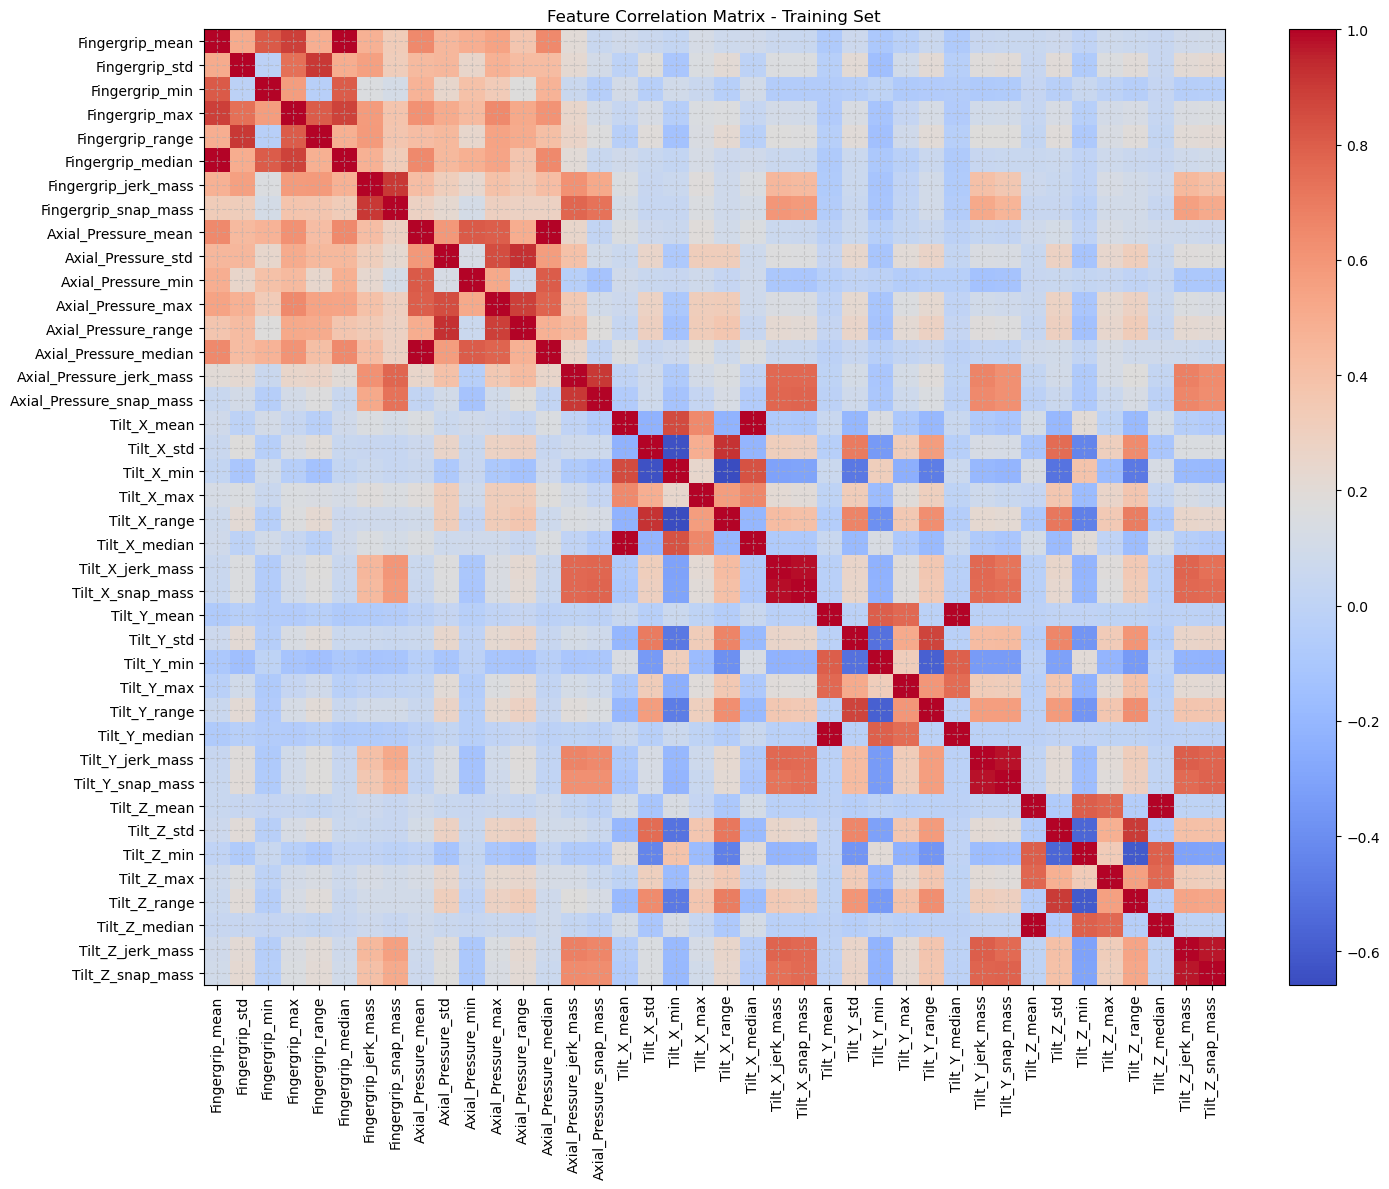


Feature Distributions in Training Set:


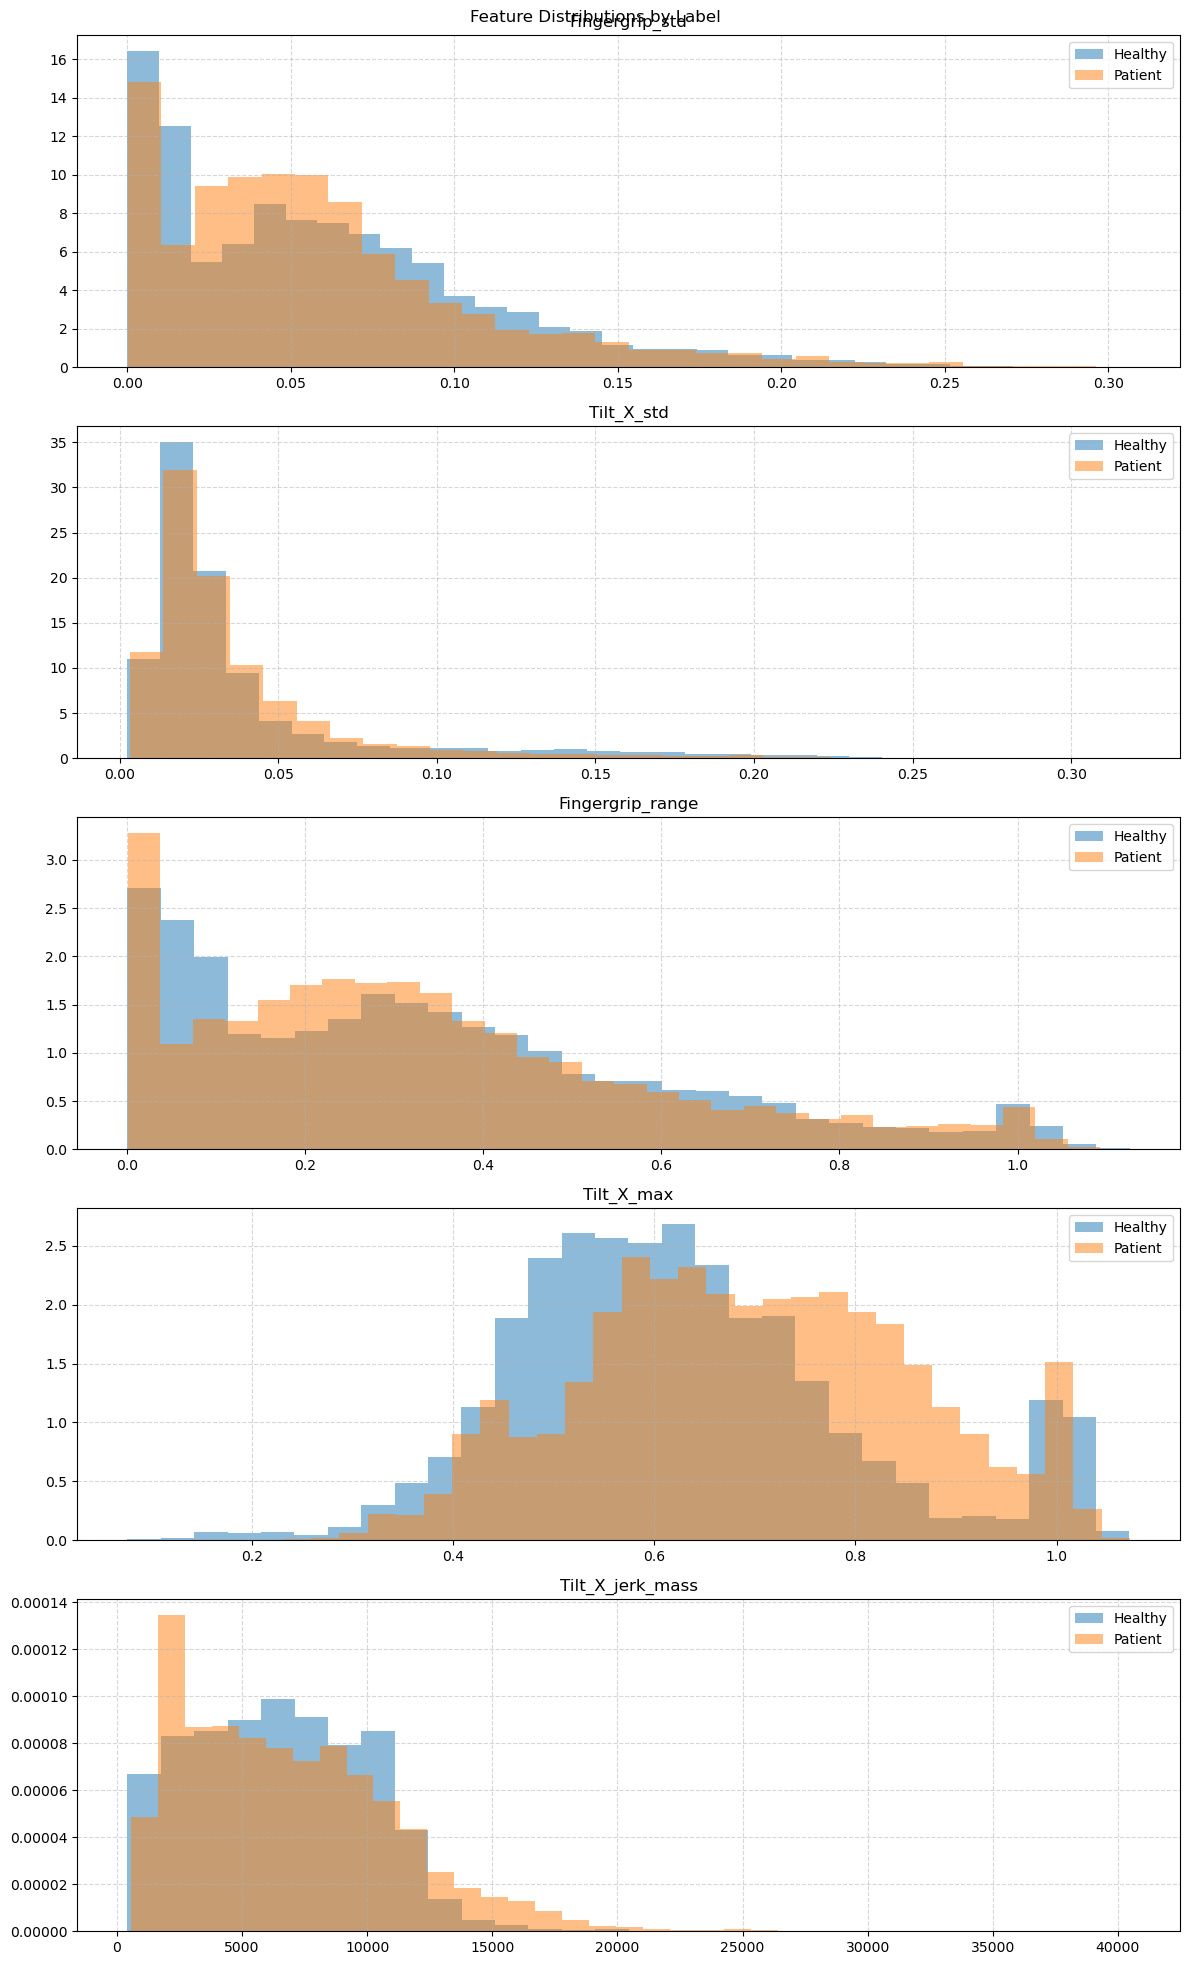

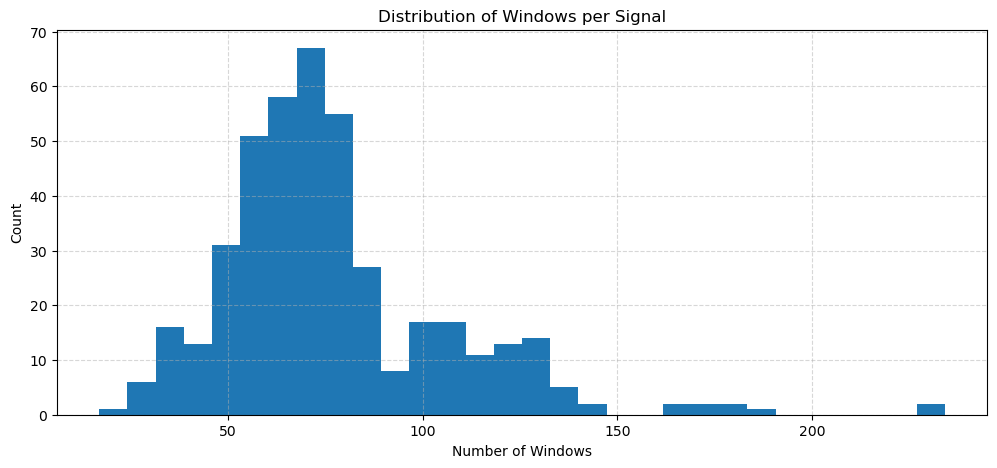


Progression of Fingergrip_mean across windows:


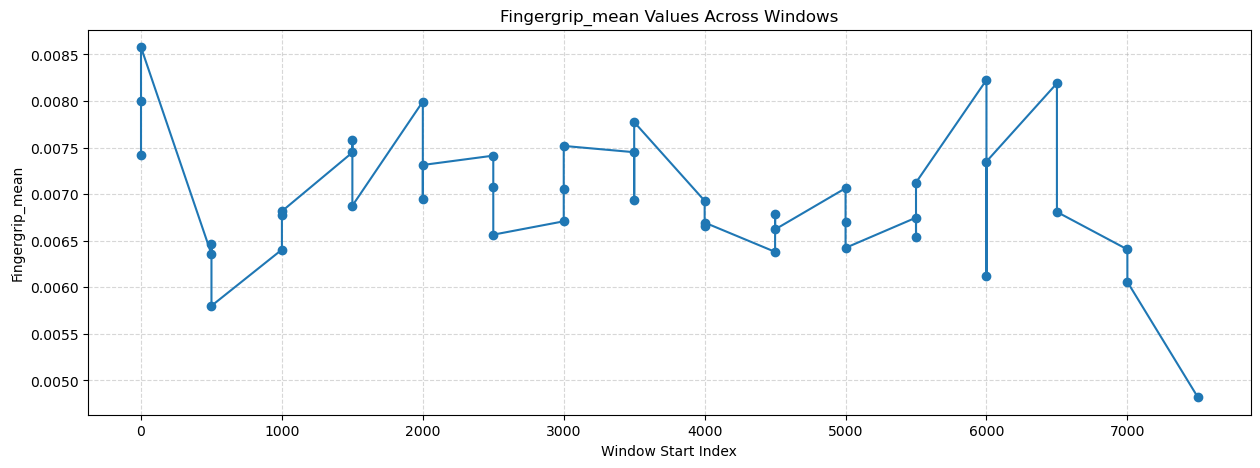


Progression of Axial_Pressure_mean across windows:


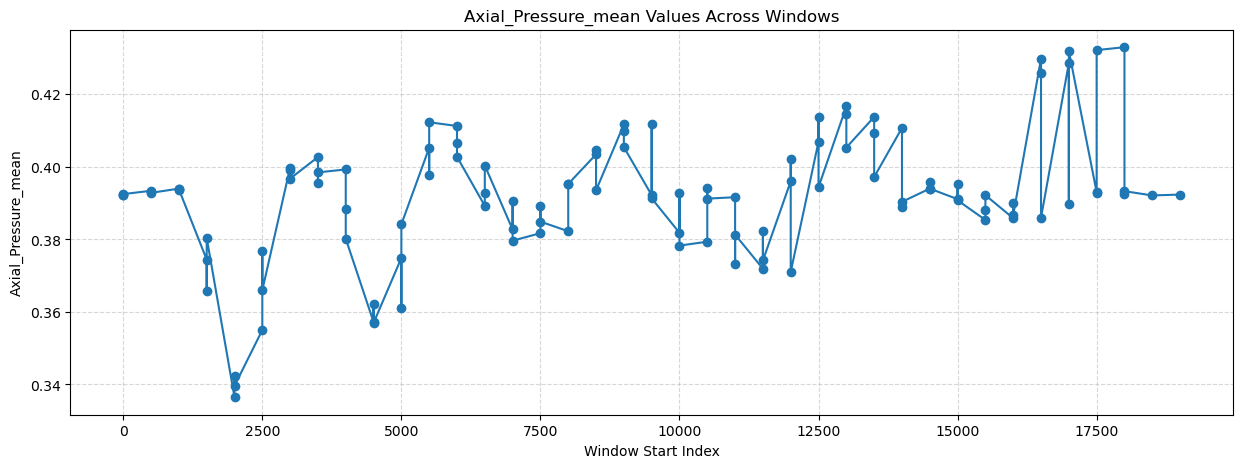


Progression of Tilt_X_mean across windows:


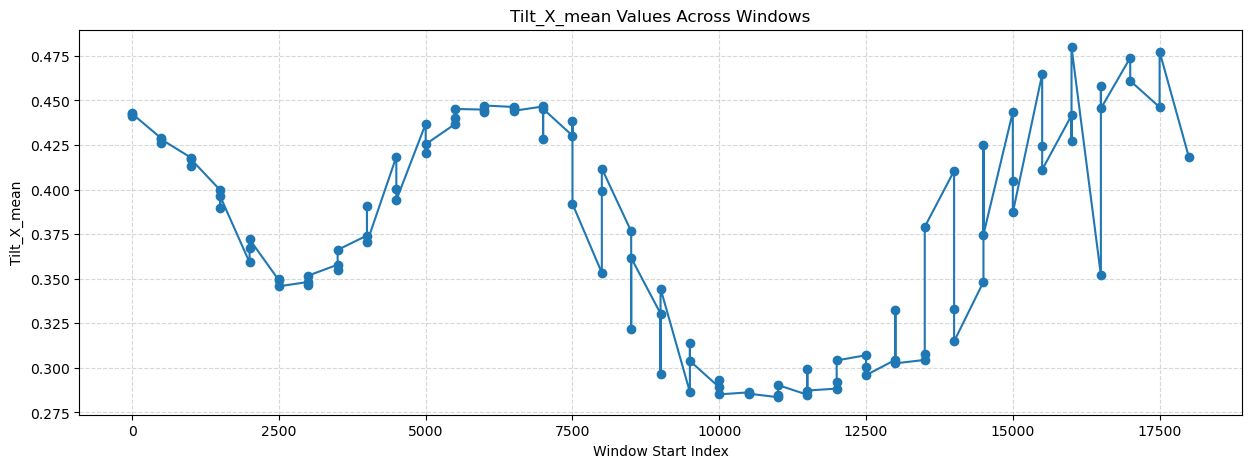


Progression of Tilt_Y_mean across windows:


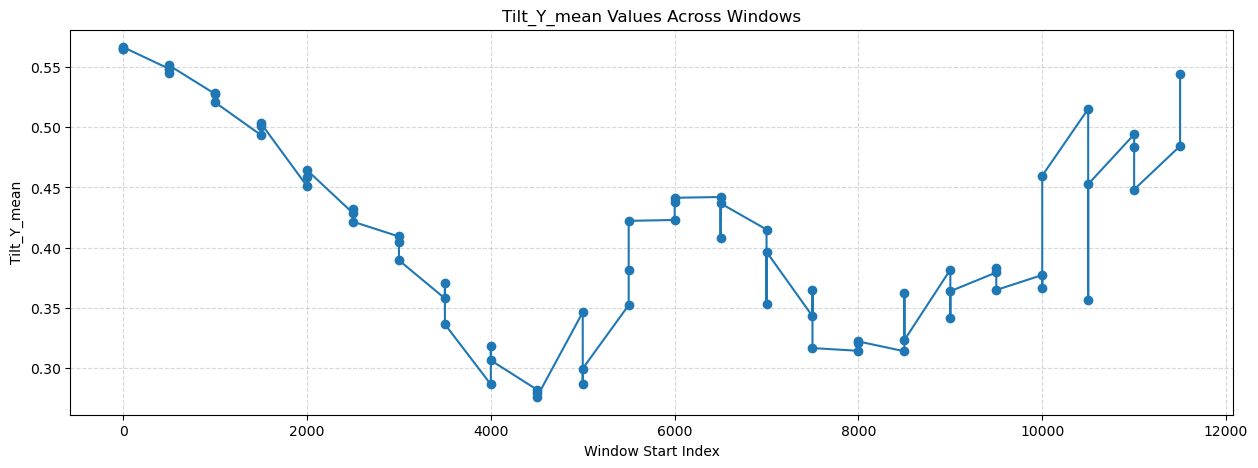


Progression of Tilt_Z_mean across windows:


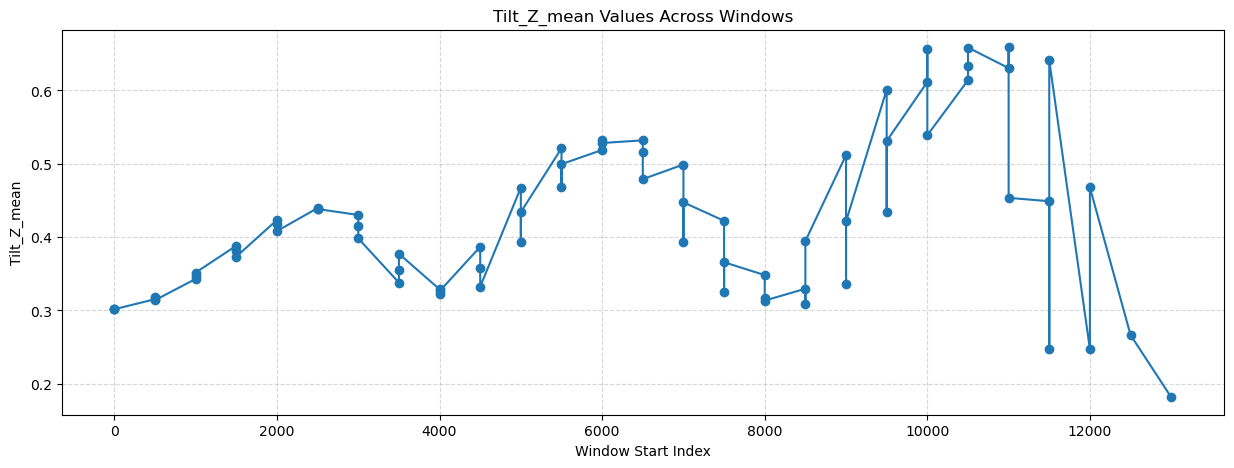

In [16]:
# Visualize extracted features
# Set up the plotting style
try:
    import seaborn as sns
    plt.style.use('seaborn')
except (ImportError, OSError):
    # If seaborn style is not available, use a clean default style
    plt.style.use('default')
    plt.rcParams['figure.facecolor'] = 'white'
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.linestyle'] = '--'
    plt.rcParams['grid.alpha'] = 0.5


# 1. Feature correlation heatmap
def plot_feature_correlations(df, title):
    # Get feature columns (excluding metadata and identifiers)
    feature_cols = [col for col in df.columns if any(
        channel in col for channel in channel_names
    )]
    
    # Calculate correlation matrix
    corr_matrix = df[feature_cols].corr()
    
    plt.figure(figsize=(15, 12))
    plt.imshow(corr_matrix, cmap='coolwarm', aspect='auto')
    plt.colorbar()
    plt.xticks(range(len(feature_cols)), feature_cols, rotation=90)
    plt.yticks(range(len(feature_cols)), feature_cols)
    plt.title(f'Feature Correlation Matrix - {title}')
    plt.tight_layout()
    plt.show()

print("Feature Correlations in Training Set:")
plot_feature_correlations(df_features_train, "Training Set")

# 2. Feature distributions by label
def plot_feature_distributions(df, num_features=5):
    # Get feature columns
    feature_cols = [col for col in df.columns if any(
        channel in col for channel in channel_names
    )]
    
    # Select a subset of features
    selected_features = np.random.choice(feature_cols, num_features, replace=False)
    
    fig, axes = plt.subplots(num_features, 1, figsize=(12, 4*num_features))
    fig.suptitle('Feature Distributions by Label')
    
    for idx, feature in enumerate(selected_features):
        healthy_data = df[df['label'] == 0][feature]
        patient_data = df[df['label'] == 1][feature]
        
        axes[idx].hist(healthy_data, bins=30, alpha=0.5, label='Healthy', density=True)
        axes[idx].hist(patient_data, bins=30, alpha=0.5, label='Patient', density=True)
        axes[idx].set_title(feature)
        axes[idx].legend()
    
    plt.tight_layout()
    plt.show()

print("\nFeature Distributions in Training Set:")
plot_feature_distributions(df_features_train)

# 3. Windows per signal distribution
plt.figure(figsize=(12, 5))
windows_per_file = df_features_train.groupby('file_name').size()
plt.hist(windows_per_file, bins=30)
plt.title('Distribution of Windows per Signal')
plt.xlabel('Number of Windows')
plt.ylabel('Count')
plt.show()

# 4. Feature values across windows
def plot_feature_progression(df, feature_name):
    plt.figure(figsize=(15, 5))
    
    # Get a random file
    sample_file = df['file_name'].sample(1).iloc[0]
    file_data = df[df['file_name'] == sample_file].sort_values('start_index')
    
    plt.plot(file_data['start_index'], file_data[feature_name], marker='o')
    plt.title(f'{feature_name} Values Across Windows')
    plt.xlabel('Window Start Index')
    plt.ylabel(feature_name)
    plt.grid(True)
    plt.show()

# Plot progression for one feature from each channel
for channel in channel_names:
    feature = f"{channel}_mean"  # using mean as example
    print(f"\nProgression of {feature} across windows:")
    plot_feature_progression(df_features_train, feature)

In [17]:
# Cell 9: Add delta features (with selected metadata columns only)
def add_delta_features(df):
    delta_features = []
    grouped = df.groupby("file_name")

    # Define only the metadata columns we want to keep
    base_non_feature_cols = [
        'label', 'file_name', 'start_index', 'end_index',
        'Person_ID_Number', 'Age', 'Gender', 'Writing_Hand',
        'augmented', 'original_duration', 'target_duration'
    ]
    
    # Identify potential metadata columns (columns that are constant within each file)
    potential_metadata_cols = [
        col for col in df.columns 
        if col not in base_non_feature_cols 
        and col in ['Person_ID_Number', 'Age', 'Gender', 'Writing_Hand']
        and df.groupby('file_name')[col].nunique().max() == 1
    ]
    
    # Combine base non-feature columns with metadata columns
    non_feature_cols = base_non_feature_cols + potential_metadata_cols

    for file_name, group in grouped:
        group = group.sort_values("start_index").reset_index(drop=True)
        group_delta = group.copy()

        # Identify feature columns (excluding non-feature columns)
        feature_cols = [col for col in group.columns if col not in non_feature_cols]
        
        # Compute deltas only for feature columns
        for col in feature_cols:
            group_delta[f"delta_{col}"] = group[col].diff()

        # Fill first row deltas with 0
        delta_cols = [f"delta_{col}" for col in feature_cols]
        group_delta.loc[0, delta_cols] = 0

        delta_features.append(group_delta)

    return pd.concat(delta_features, ignore_index=True)

# Process each split
print("Adding delta features to training set...")
df_delta_train = add_delta_features(df_features_train)
print("Adding delta features to test set...")
df_delta_test = add_delta_features(df_features_test)

print("\nFinal shapes:")
print(f"Training set: {df_delta_train.shape}")
print(f"Test set: {df_delta_test.shape}")

# Show columns with missing values and how many missing in each
print("\nColumns with missing values in df_delta_train:")
print(df_delta_train.isna().sum()[df_delta_train.isna().sum() > 0])

print("\nColumns with missing values in df_delta_test:")
print(df_delta_test.isna().sum()[df_delta_test.isna().sum() > 0])

Adding delta features to training set...
Adding delta features to test set...

Final shapes:
Training set: (32376, 91)
Test set: (2960, 88)

Columns with missing values in df_delta_train:
original_duration    13909
target_duration      13909
dtype: int64

Columns with missing values in df_delta_test:
Series([], dtype: int64)


# Model Training: Support Vector Machines (SVM) with Random Search
- Feature Scaling: Applying StandardScaler to normalize the feature sets.
- Hyperparameter Tuning: Using RandomSearchCV to find the optimal SVM hyperparameters.
- Model Evaluation: Assessing the best model's performance on the test set.

In [18]:
# Cell 10: Imports for Modeling and Evaluation
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import expon, uniform

In [19]:
# Cell 11: Prepare Data for Modeling

# Identify feature columns by excluding metadata and identifiers
non_feature_cols = ['label', 'file_name', 'start_index', 'end_index', 'Person_ID_Number', 'Age', 'Gender', 'Writing_Hand', 'augmented', 'original_duration', 'target_duration']
feature_cols = [col for col in df_delta_train.columns if col not in non_feature_cols]

# Create feature and target sets
X_train = df_delta_train[feature_cols]
y_train = df_delta_train['label']

X_test = df_delta_test[feature_cols]
y_test = df_delta_test['label']

# --- Feature Scaling ---
# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler ONLY on the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the validation and test data using the same scaler
X_test_scaled = scaler.transform(X_test)

print(f"Feature shapes after scaling:")
print(f"X_train_scaled: {X_train_scaled.shape}")
print(f"X_test_scaled: {X_test_scaled.shape}")

Feature shapes after scaling:
X_train_scaled: (32376, 80)
X_test_scaled: (2960, 80)


In [ ]:
# Cell 12: SVM with Randomized Search
# Define the parameter distribution for Randomized Search
param_dist = {
    'C': uniform(0.1, 100),  # Regularization parameter
    'gamma': expon(scale=0.1),  # Kernel coefficient for 'rbf'
    'kernel': ['rbf', 'poly', 'sigmoid']  # Type of kernel
}

# Initialize the SVM classifier
svm = SVC(probability=True, random_state=42)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=svm,
    param_distributions=param_dist,
    n_iter=50,  # Number of parameter settings that are sampled
    cv=3,  # 3-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1  # Use all available cores
)

# Fit the random search to the data
print("\nStarting Randomized Search for SVM hyperparameters...")
random_search.fit(X_train_scaled, y_train)

# Print the best parameters found
print("\nBest parameters found by Randomized Search:")
print(random_search.best_params_)


Starting Randomized Search for SVM hyperparameters...
Fitting 3 folds for each of 50 candidates, totalling 150 fits

Best parameters found by Randomized Search:
{'C': 15.699452033620265, 'gamma': 0.005983876860868068, 'kernel': 'rbf'}


Test Set Accuracy: 0.8564

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.87      0.84      0.85      1486
     Patient       0.84      0.87      0.86      1474

    accuracy                           0.86      2960
   macro avg       0.86      0.86      0.86      2960
weighted avg       0.86      0.86      0.86      2960

Confusion Matrix:


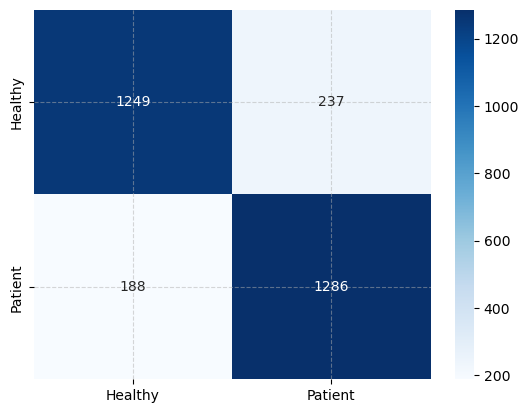

In [21]:
# Cell 13: Evaluate the Best Model on the Test Set
# Get the best model
best_svm_model = random_search.best_estimator_

y_pred = best_svm_model.predict(X_test_scaled)

test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Set Accuracy: {test_accuracy:.4f}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Healthy', 'Patient']))

print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Healthy', 'Patient'], yticklabels=['Healthy', 'Patient'])
plt.show()